# CS4035 - Cyber Data Analytics
## Lab 2 - LOF/Ngram

## Group Number : 21

## Student 1 
### Name : Krzysztof Baran
### ID : 4662148

In [245]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.preprocessing import KBinsDiscretizer
%matplotlib inline

## 0. Data Loading

#### Loading into pandas dataframe

In [91]:
train_data_path = os.path.join(os.getcwd(), "data", "train_data.csv")
val_data_path = os.path.join(os.getcwd(), "data", "val_data.csv")
test_data_path = os.path.join(os.getcwd(), "data", "test_data.csv")

train_data_df = pd.read_csv(train_data_path)
train_data_df.set_index('Id', inplace=True)
val_data_df = pd.read_csv(val_data_path)
val_data_df.set_index('Id', inplace=True)
test_data_df = pd.read_csv(test_data_path)
test_data_df.set_index('Id', inplace=True)

In [92]:
SENSOR_ATTRIBUTES = [
    'FIT101', 'LIT101', 'AIT201', 'AIT202', 'AIT203',
    'FIT201', 'DPIT301', 'FIT301', 'LIT301', 'AIT401',
    'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502',
    'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503',
    'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601'
]

ACTUATOR_ATTRIBUTES = [
    'MV101', 'P101', 'P102', 'MV201', 'P201', 'P202',
    'P203', 'P204', 'P205', 'P206', 'MV301', 'MV302',
    'MV303', 'MV304', 'P301', 'P302', 'P401',
    'P402', 'P403', 'P404', 'UV401', 'P501', 'P502',
    'P601', 'P602', 'P603'
]

useless_attributes = []
for col in pd.concat([train_data_df[ACTUATOR_ATTRIBUTES], val_data_df[ACTUATOR_ATTRIBUTES], test_data_df[ACTUATOR_ATTRIBUTES]], axis=0):
    unique_attrs = train_data_df[col].unique()
    if len(unique_attrs) == 1:
        useless_attributes.append(col)

all_attributes = []
all_attributes.extend(SENSOR_ATTRIBUTES)
all_attributes.extend(ACTUATOR_ATTRIBUTES)
relevant_attributes = [attr for attr in all_attributes if attr not in useless_attributes]
data_df = train_data_df[relevant_attributes]
data_df

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV301,MV302,MV303,MV304,P301,P302,P402,UV401,P501,P602
Id,,,,,,,,,,,,,,,,,,,,,
0,2.470294,261.5804,244.3284,8.190080,306.1010,2.471278,20.79839,2.235275,327.4401,0.000,...,1,2,1,1,2,1,1,1,1,1
1,2.457163,261.1879,244.3284,8.190080,306.1010,2.468587,20.79839,2.234507,327.4401,0.000,...,1,2,1,1,2,1,1,1,1,1
2,2.439548,260.9131,244.3284,8.190080,306.1010,2.467305,20.84320,2.233354,327.4401,0.000,...,1,2,1,1,2,1,1,1,1,1
3,2.428338,260.2850,244.3284,8.190080,306.1010,2.466536,20.84320,2.233354,327.2799,0.000,...,1,2,1,1,2,1,1,1,1,1
4,2.424815,259.8925,244.4245,8.190080,306.1010,2.466536,20.84320,2.233354,327.1597,0.000,...,1,2,1,1,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496795,2.460366,523.0430,262.0161,8.396437,328.5055,2.442316,19.74838,2.212087,955.8046,148.808,...,1,2,1,1,1,2,2,2,2,1
496796,2.448836,522.9645,262.0161,8.396437,328.5055,2.442316,19.74838,2.210037,955.8847,148.808,...,1,2,1,1,1,2,2,2,2,1
496797,2.434744,522.8860,262.0161,8.396437,328.6337,2.444879,19.74838,2.207731,955.9648,148.808,...,1,2,1,1,1,2,2,2,2,1


In [93]:
sqrt_data_len = int(np.sqrt(len(train_data_df)))
neighbor_values = [2, 5, 11, 51, 75, 101, int(sqrt_data_len / 2), sqrt_data_len]
neighbor_values

[2, 5, 11, 51, 75, 101, 352, 704]

## 2. LOF task – 1/2 A4 – Individual

### 2a. Plot LOF scores

**WARNING**: This can take 50-60 minutes to run!!! Get a cup of coffee and let it run! It will push your CPU to the limit

In [502]:
# Find anomalies
def find_anomalies(residuals, threshold):
    res = np.abs(residuals)
    res[res > threshold] = 1
    res[res <= threshold] = 0
    return res


# Calculate the number of true positives, false positives, true negatives and false negatives
def calculate_statistics(predictions, labels):
    # Calculate true positives
    true_positives = np.sum(np.logical_and(predictions == 1, labels == 1))
    # Calculate false positives
    false_positives = np.sum(np.logical_and(predictions == 1, labels == 0))
    # Calculate true negatives
    true_negatives = np.sum(np.logical_and(predictions == 0, labels == 0))
    # Calculate false negatives
    false_negatives = np.sum(np.logical_and(predictions == 0, labels == 1))
    return true_positives, false_positives, true_negatives, false_negatives


def calculate_metrics(tp, fp, tn, fn):
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    return accuracy, precision, recall, f1_score

In [94]:
lof_scores = {}
preds = {}
for i in tqdm(range(len(neighbor_values))):
    clf = LocalOutlierFactor(n_neighbors=neighbor_values[i], n_jobs=-1)
    pred = clf.fit_predict(data_df)
    lof_score = - clf.negative_outlier_factor_

    lof_scores[neighbor_values[i]] = lof_score
    preds[neighbor_values[i]] = pred

100%|██████████| 8/8 [49:58<00:00, 374.85s/it]


In [95]:
k_vals = sorted(neighbor_values)

<Figure size 640x480 with 0 Axes>

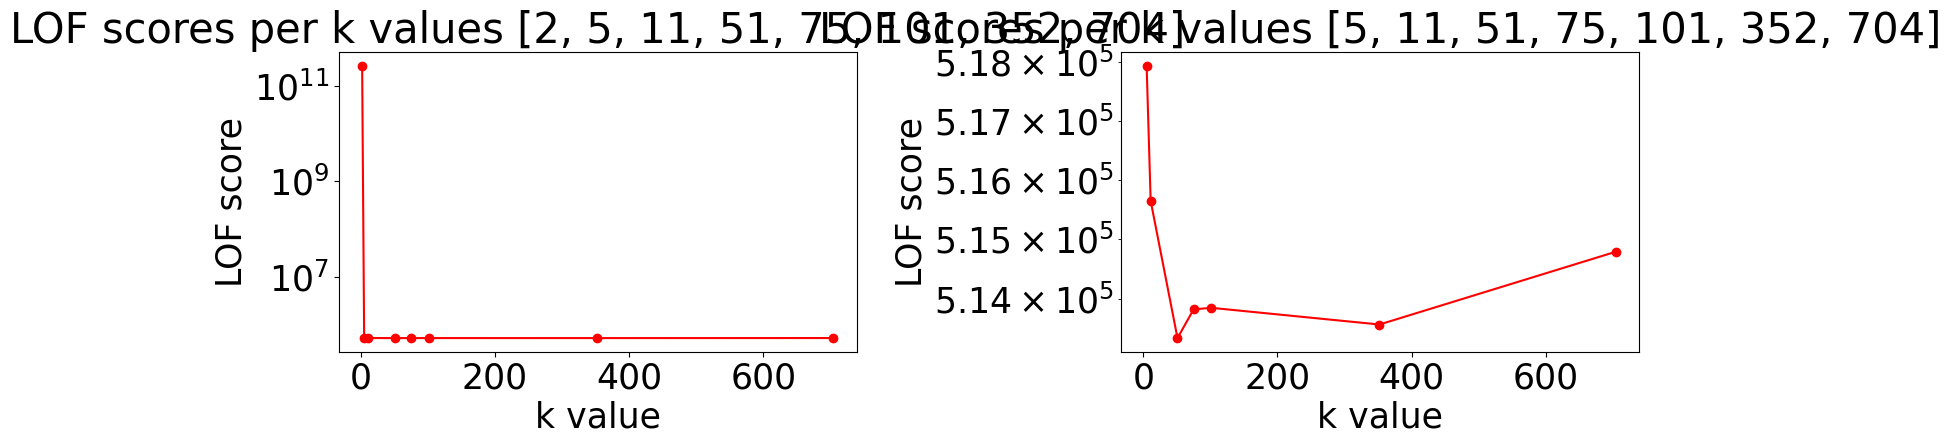

In [96]:
plt.clf()
lof_scores_arr = np.array([lof_scores[scores] for scores in lof_scores])
lof_scores_arr = np.sum(lof_scores_arr, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
for i, ax in enumerate(axes.flatten()):
    ax.plot(neighbor_values[i:], lof_scores_arr[i:], '-ro')
    ax.set_title(f'LOF scores per k values {neighbor_values[i:]}')

    ax.set_xlabel('k value')
    ax.set_ylabel('LOF score')
    ax.set_yscale('log')

plt.tight_layout()
plt.show()

In [97]:
curr_pred = np.array([preds[k] for k in preds])
curr_pred[curr_pred == 1] = 0
curr_pred[curr_pred == -1] = 1
sum_anomalies = np.sum(curr_pred, axis=1)

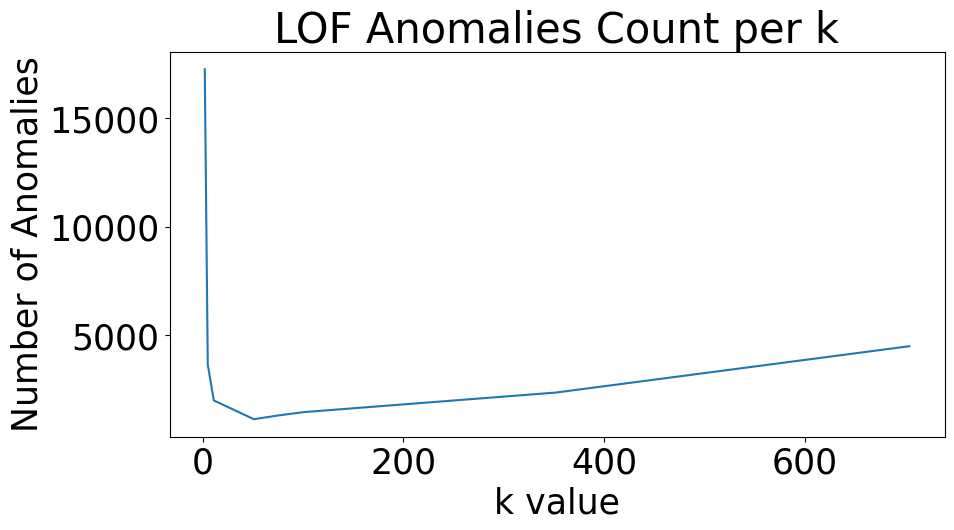

In [98]:
plt.figure(figsize=(10, 5))

plt.plot(neighbor_values, sum_anomalies)

plt.title("LOF Anomalies Count per k")

plt.xlabel("k value")
plt.ylabel("Number of Anomalies")

plt.show()

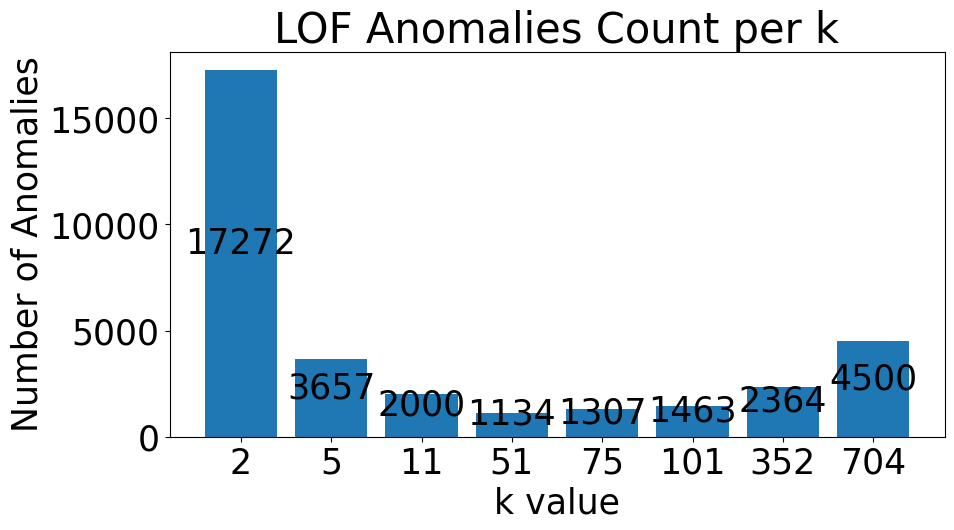

In [99]:
# function to add value labels
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha='center')


plt.figure(figsize=(10, 5))

plt.bar([f"{k}" for k in neighbor_values], sum_anomalies)

addlabels(neighbor_values, sum_anomalies)

plt.title("LOF Anomalies Count per k")

plt.xlabel("k value")
plt.ylabel("Number of Anomalies")

plt.show()

/tmp/ipykernel_30/581734376.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=45)


<Figure size 640x480 with 0 Axes>

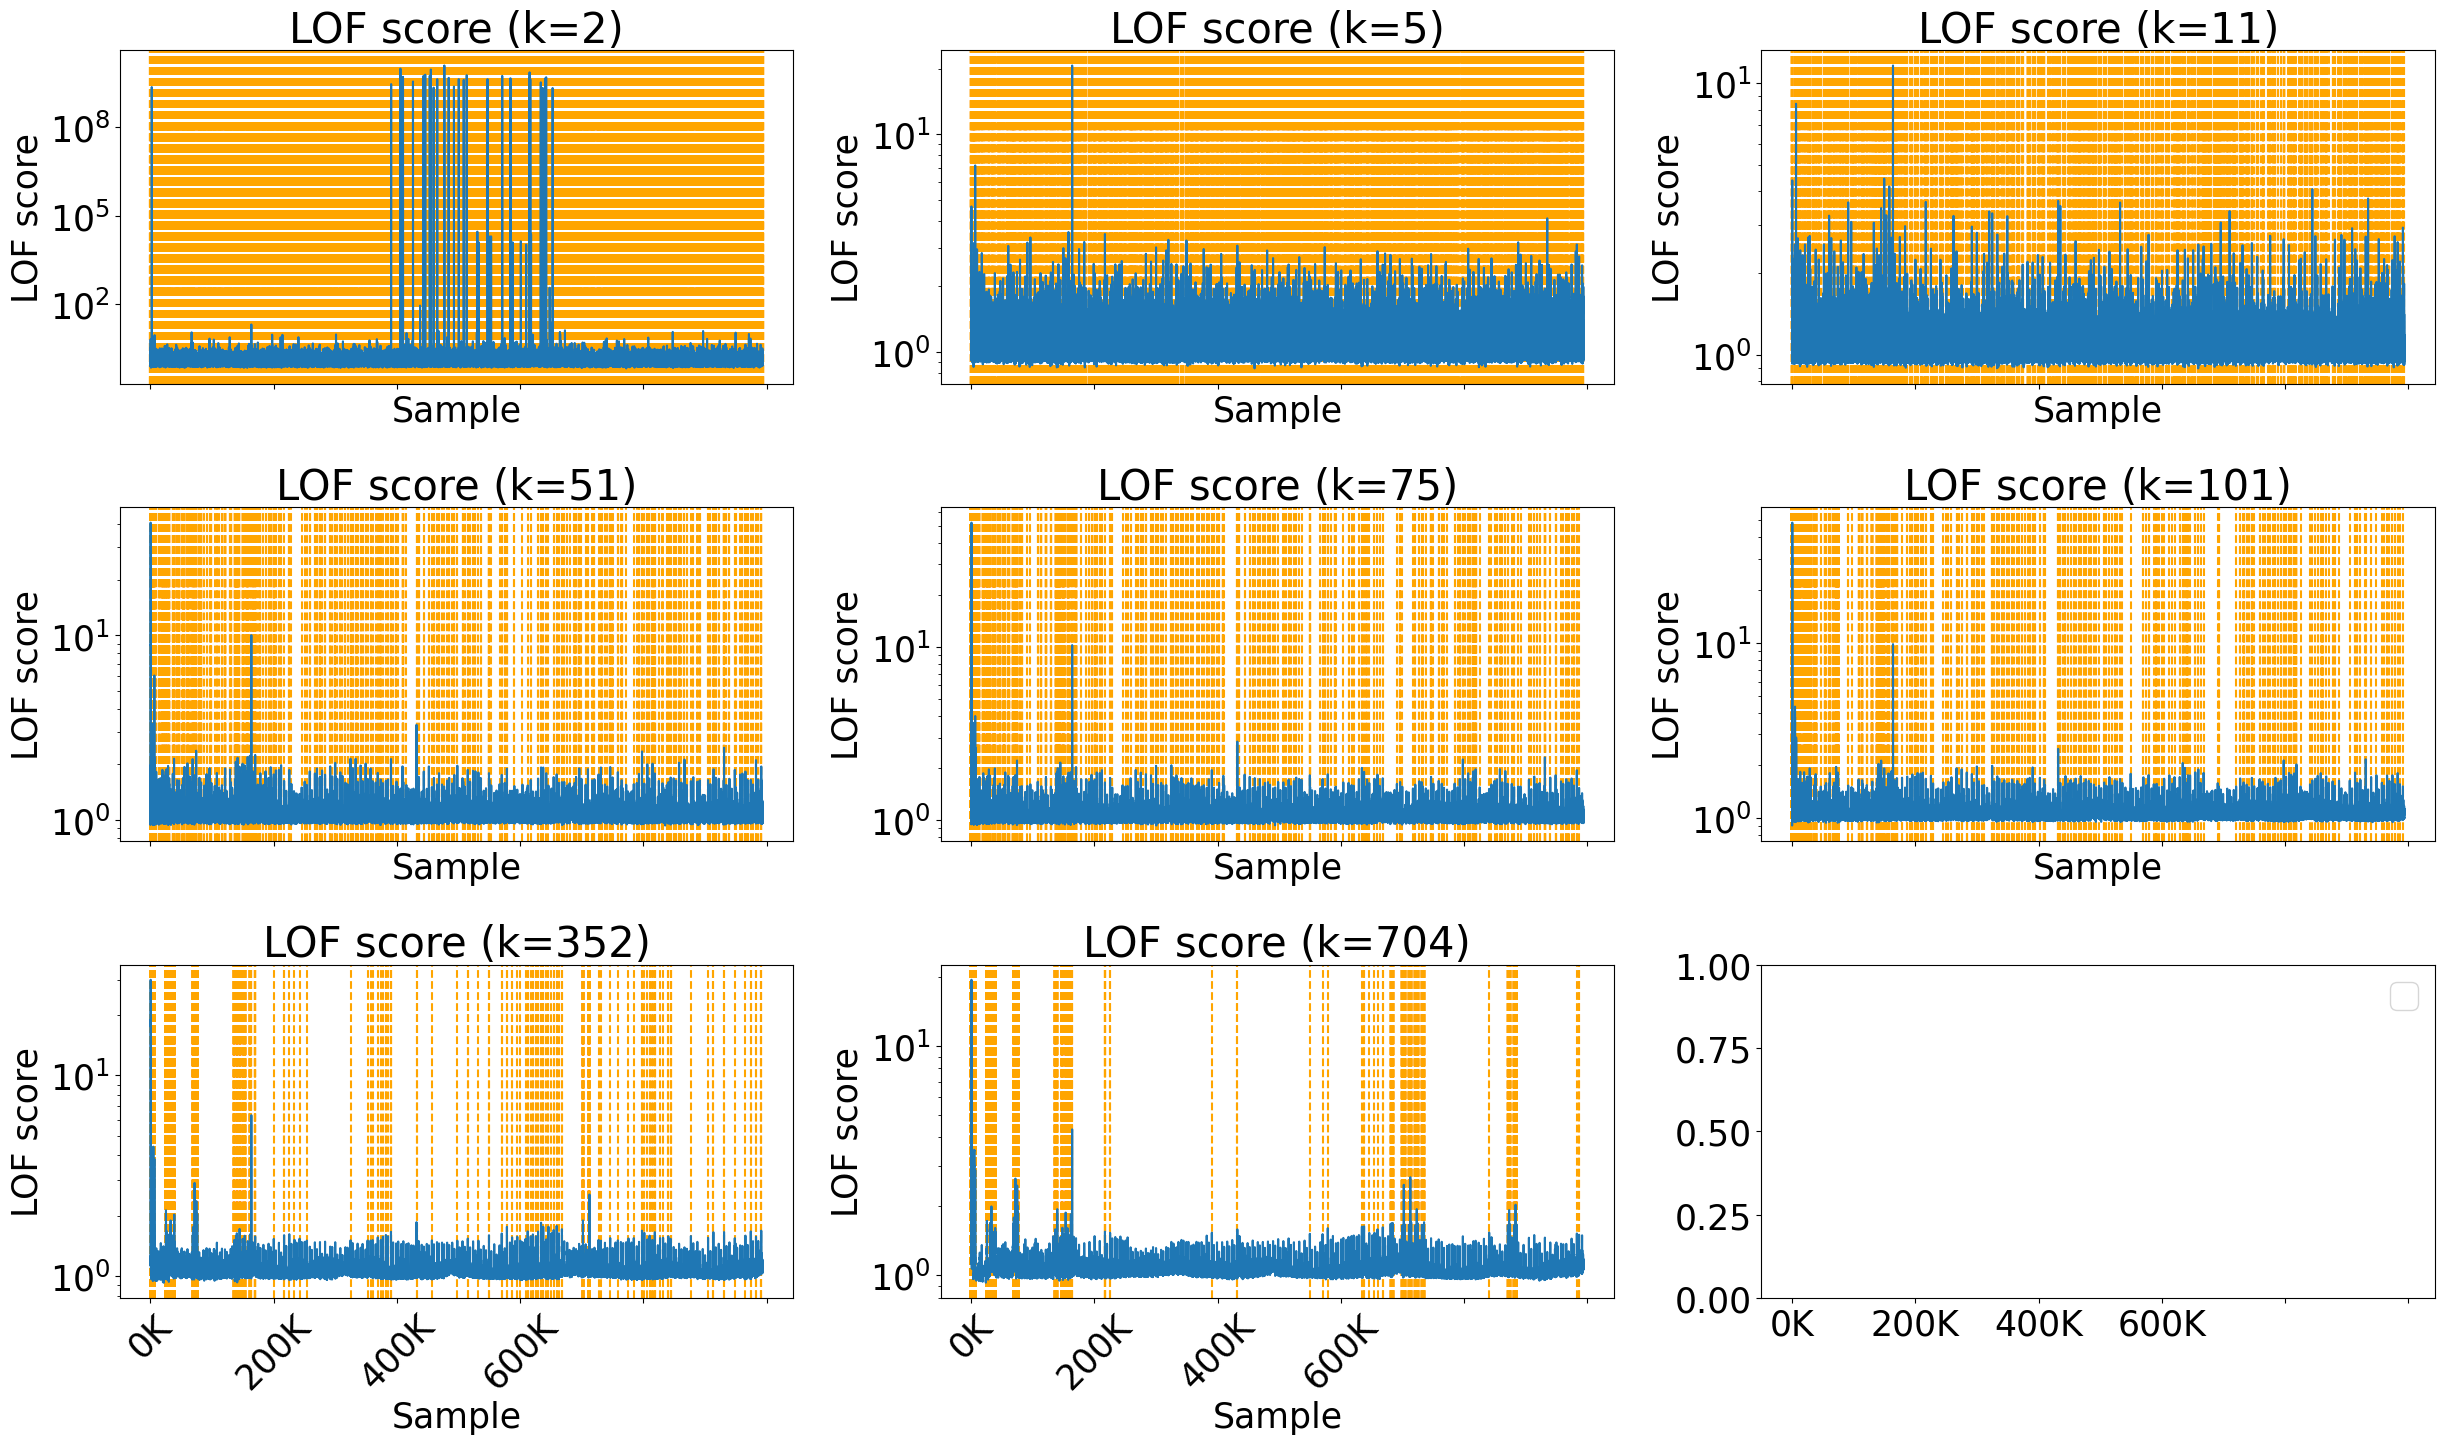

In [100]:
sqr_fig = int(np.ceil(np.sqrt(len(k_vals))))

plt.rcParams.update({'font.size': 25})
plt.clf()

fig, axes = plt.subplots(sqr_fig, sqr_fig, figsize=(25, 15), sharex=True)
for i, ax in enumerate(axes.flatten()):
    if i >= len(k_vals):
        break
    arr = lof_scores[k_vals[i]]

    max_value = np.max(arr)
    curr_pred = np.array(preds[k_vals[i]])
    curr_pred[curr_pred == 1] = 0
    curr_pred[curr_pred == -1] = max_value

    indexes = np.where(curr_pred != 0)[0]
    for index in indexes:
        ax.axvline(index, linestyle='--', color="orange")
    ax.plot(np.arange(len(arr)), arr)

    ax.set_title(f'LOF score (k={k_vals[i]})')

    ax.set_xlabel('Sample')
    ax.set_ylabel('LOF score')
    ax.set_yscale('log')
    xlabels = [f'{x:,.0f}K' for x in ax.get_xticks()/1000]
    ax.set_xticklabels(xlabels, rotation=45)

plt.tight_layout()
plt.legend(["LOF", "isOutlier"])
plt.show()

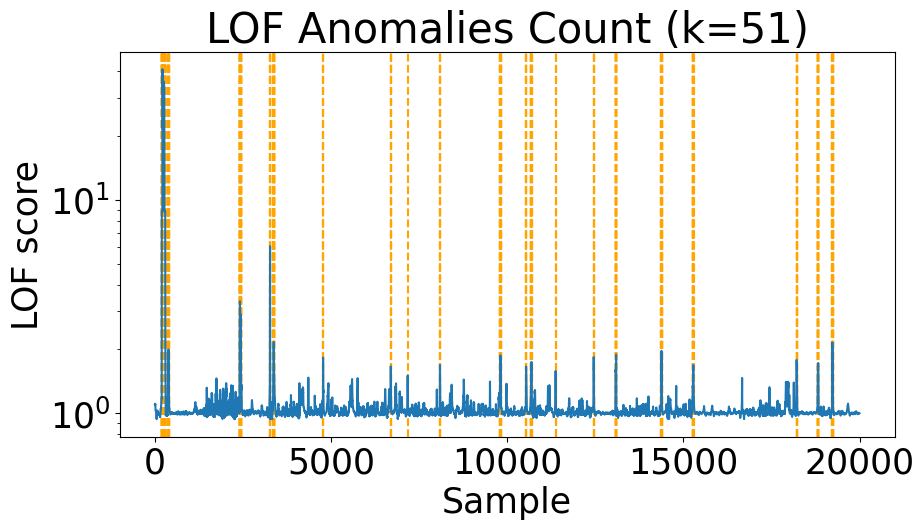

In [101]:
plt.figure(figsize=(10, 5))

anomalies_k_51 = np.array(lof_scores[51][:20000])
curr_pred = np.array(preds[51][:20000])
curr_pred[curr_pred == 1] = 0
curr_pred[curr_pred == -1] = 1

indexes = np.where(curr_pred == 1)[0]
for index in indexes:
    plt.axvline(index, linestyle='--', color="orange")

plt.plot(np.arange(len(anomalies_k_51)), anomalies_k_51)

plt.title("LOF Anomalies Count (k=51)")

plt.xlabel("Sample")
plt.ylabel("LOF score")
plt.yscale('log')
plt.show()

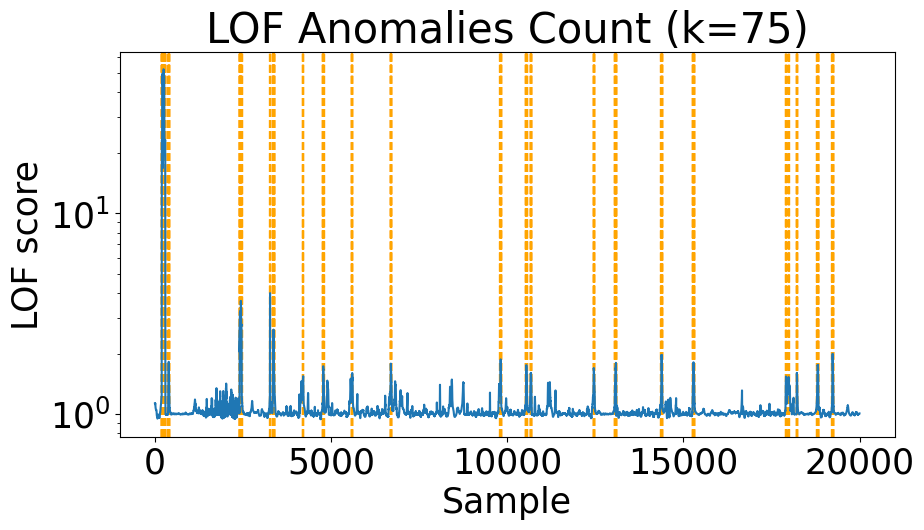

In [102]:
plt.figure(figsize=(10, 5))

anomalies_k_75 = np.array(lof_scores[75][:20000])
curr_pred = np.array(preds[75][:20000])
curr_pred[curr_pred == 1] = 0
curr_pred[curr_pred == -1] = 1

indexes = np.where(curr_pred == 1)[0]
for index in indexes:
    plt.axvline(index, linestyle='--', color="orange")

plt.plot(np.arange(len(anomalies_k_75)), anomalies_k_75)

plt.title("LOF Anomalies Count (k=75)")

plt.xlabel("Sample")
plt.ylabel("LOF score")
plt.yscale('log')
plt.show()

In [111]:
curr_pred = np.array(preds[51][:20000])

abnormal_indexes = np.where(curr_pred == -1)[0]
train_data_no_anomalies_df = train_data_df.drop(train_data_df.index[indexes])[relevant_attributes]

In [112]:
clf = LocalOutlierFactor(n_neighbors=51, n_jobs=-1)
pred = clf.fit_predict(train_data_no_anomalies_df)
lof_score = - clf.negative_outlier_factor_

In [113]:
# Number of outliers
len(np.where(pred == -1)[0])

949

In [114]:
# Sum of LOF scores
np.sum(lof_score)

510653.3246186522

In [115]:
curr_pred = np.array(preds[75][:20000])

abnormal_indexes = np.where(curr_pred == -1)[0]

In [116]:
clf = LocalOutlierFactor(n_neighbors=75, n_jobs=-1)
pred = clf.fit_predict(train_data_no_anomalies_df)
lof_score = - clf.negative_outlier_factor_

In [117]:
# Number of outliers
len(np.where(pred == -1)[0])

1100

In [118]:
# Sum of LOF scores
np.sum(lof_score)

510088.7471134655

In [491]:
clf = LocalOutlierFactor(n_neighbors=51, n_jobs=-1)
pred = clf.fit_predict(val_data_df[relevant_attributes])
pred[pred == 1] = 0
pred[pred == -1] = 1
labels = val_data_df["Label"].to_numpy()

In [500]:
tp, fp, tn, fn = calculate_statistics(pred, labels)
print(f"True positives: {tp}\nFalse positives: {fp}\nTrue negatives: {tn}\nFalse negatives: {fn}")

True positives: 238
False positives: 1056
True negatives: 212867
False negatives: 10798


In [501]:
accuracy, precision, recall, f1_score = calculate_metrics(tp, fp, tn, fn)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1_score}")

Accuracy: 0.9473059535293098
Precision: 0.1839258114374034
Recall: 0.021565784704603116
F1 score: 0.03860502838605029


### 2b. Analysis and answers to the questions

We chose four sensors to analyze for anomalies all the attributes that are not . We executed LOF for 2, 5, 11, 51, 75, 101, 352 (half of the last value) and 704 (square root of data length) neighbors. We first took lower values, like 2 and 5, then some odd values, half of the square root of the data length (352) and the square root of the data length (704).

For k value, usually, the lower values of k tend to make the algorithm more sensitive to outliers since they have a larger impact on the calculation of distances and neighbor relations. The higher k values can provide a smoother decision boundary and may be less influenced by individual outliers. As we can see, the from the score sums of LOF, the lower k values for NN, causes the LOF to be too sensitive whereas the 
higher values are less sensitive. A common occurence seems to be that the first values seem to be abnormal which is likely because the sub-systems are getting setup and they not started any of their regular cycles.

As we can see from the total LOF scores and anolalies count, k=51 seems to the smallest and after further investivation of removing these anomalies, it seems that 51 seems to be less sensitive to small outliers.

Due to many features, LOF can be used to model point anomalies faily well. However, this is heavily impaired by its slow runtime.

## 5. N-gram task – 1/2 A4 - Individual

### 5a. Visualise discretization

#### Discretization

In [506]:
# Convert date_column to DateTime format
train_data_df['Timestamp'] = pd.to_datetime(train_data_df['Timestamp'])

# Sort DataFrame by date_column
df = train_data_df.sort_values('Timestamp')

# Select columns to discretize
columns_to_discretize = ["AIT203", "LIT101"]

In [507]:
# Initialize the discretizer
def discrete_values(disc, data):
    vectorizer = np.vectorize(lambda x: int(disc.bin_edges_[0][int(x)]))
    return vectorizer(data)


def discretized_data(data_to_discretize, n_bins=10, discretised_vals=True):
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    discretizer.fit(data_to_discretize)
    transformed_data = np.squeeze(discretizer.transform(data_to_discretize))
    if not discretised_vals:
        return transformed_data
    vals = discrete_values(discretizer, transformed_data)
    return np.array([transformed_data, vals]).T

discretized_data_ait = discretized_data(df[["AIT203"]].to_numpy())
discretized_data_lit = discretized_data(df[["LIT101"]].to_numpy())

disretized_data = np.concatenate((discretized_data_ait, discretized_data_lit), axis=1)
disretized_data

/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


array([[  0., 300.,   0., 120.],
       [  0., 300.,   0., 120.],
       [  0., 300.,   0., 120.],
       ...,
       [  3., 328.,   4., 518.],
       [  3., 328.,   4., 518.],
       [  3., 328.,   4., 518.]])

In [508]:
discretized_df = pd.DataFrame(
    disretized_data,
    columns=[
        'AIT203_percentile',
        'AIT203_discretized',
        'LIT101_percentile',
        'LIT101_discretized'
    ]
)
discretized_df

,AIT203_percentile,AIT203_discretized,LIT101_percentile,LIT101_discretized
0,0.0,300.0,0.0,120.0
1,0.0,300.0,0.0,120.0
2,0.0,300.0,0.0,120.0
3,0.0,300.0,0.0,120.0
4,0.0,300.0,0.0,120.0
...,...,...,...,...
496795,3.0,328.0,4.0,518.0
496796,3.0,328.0,4.0,518.0
496797,3.0,328.0,4.0,518.0
496798,3.0,328.0,4.0,518.0


<Figure size 640x480 with 0 Axes>

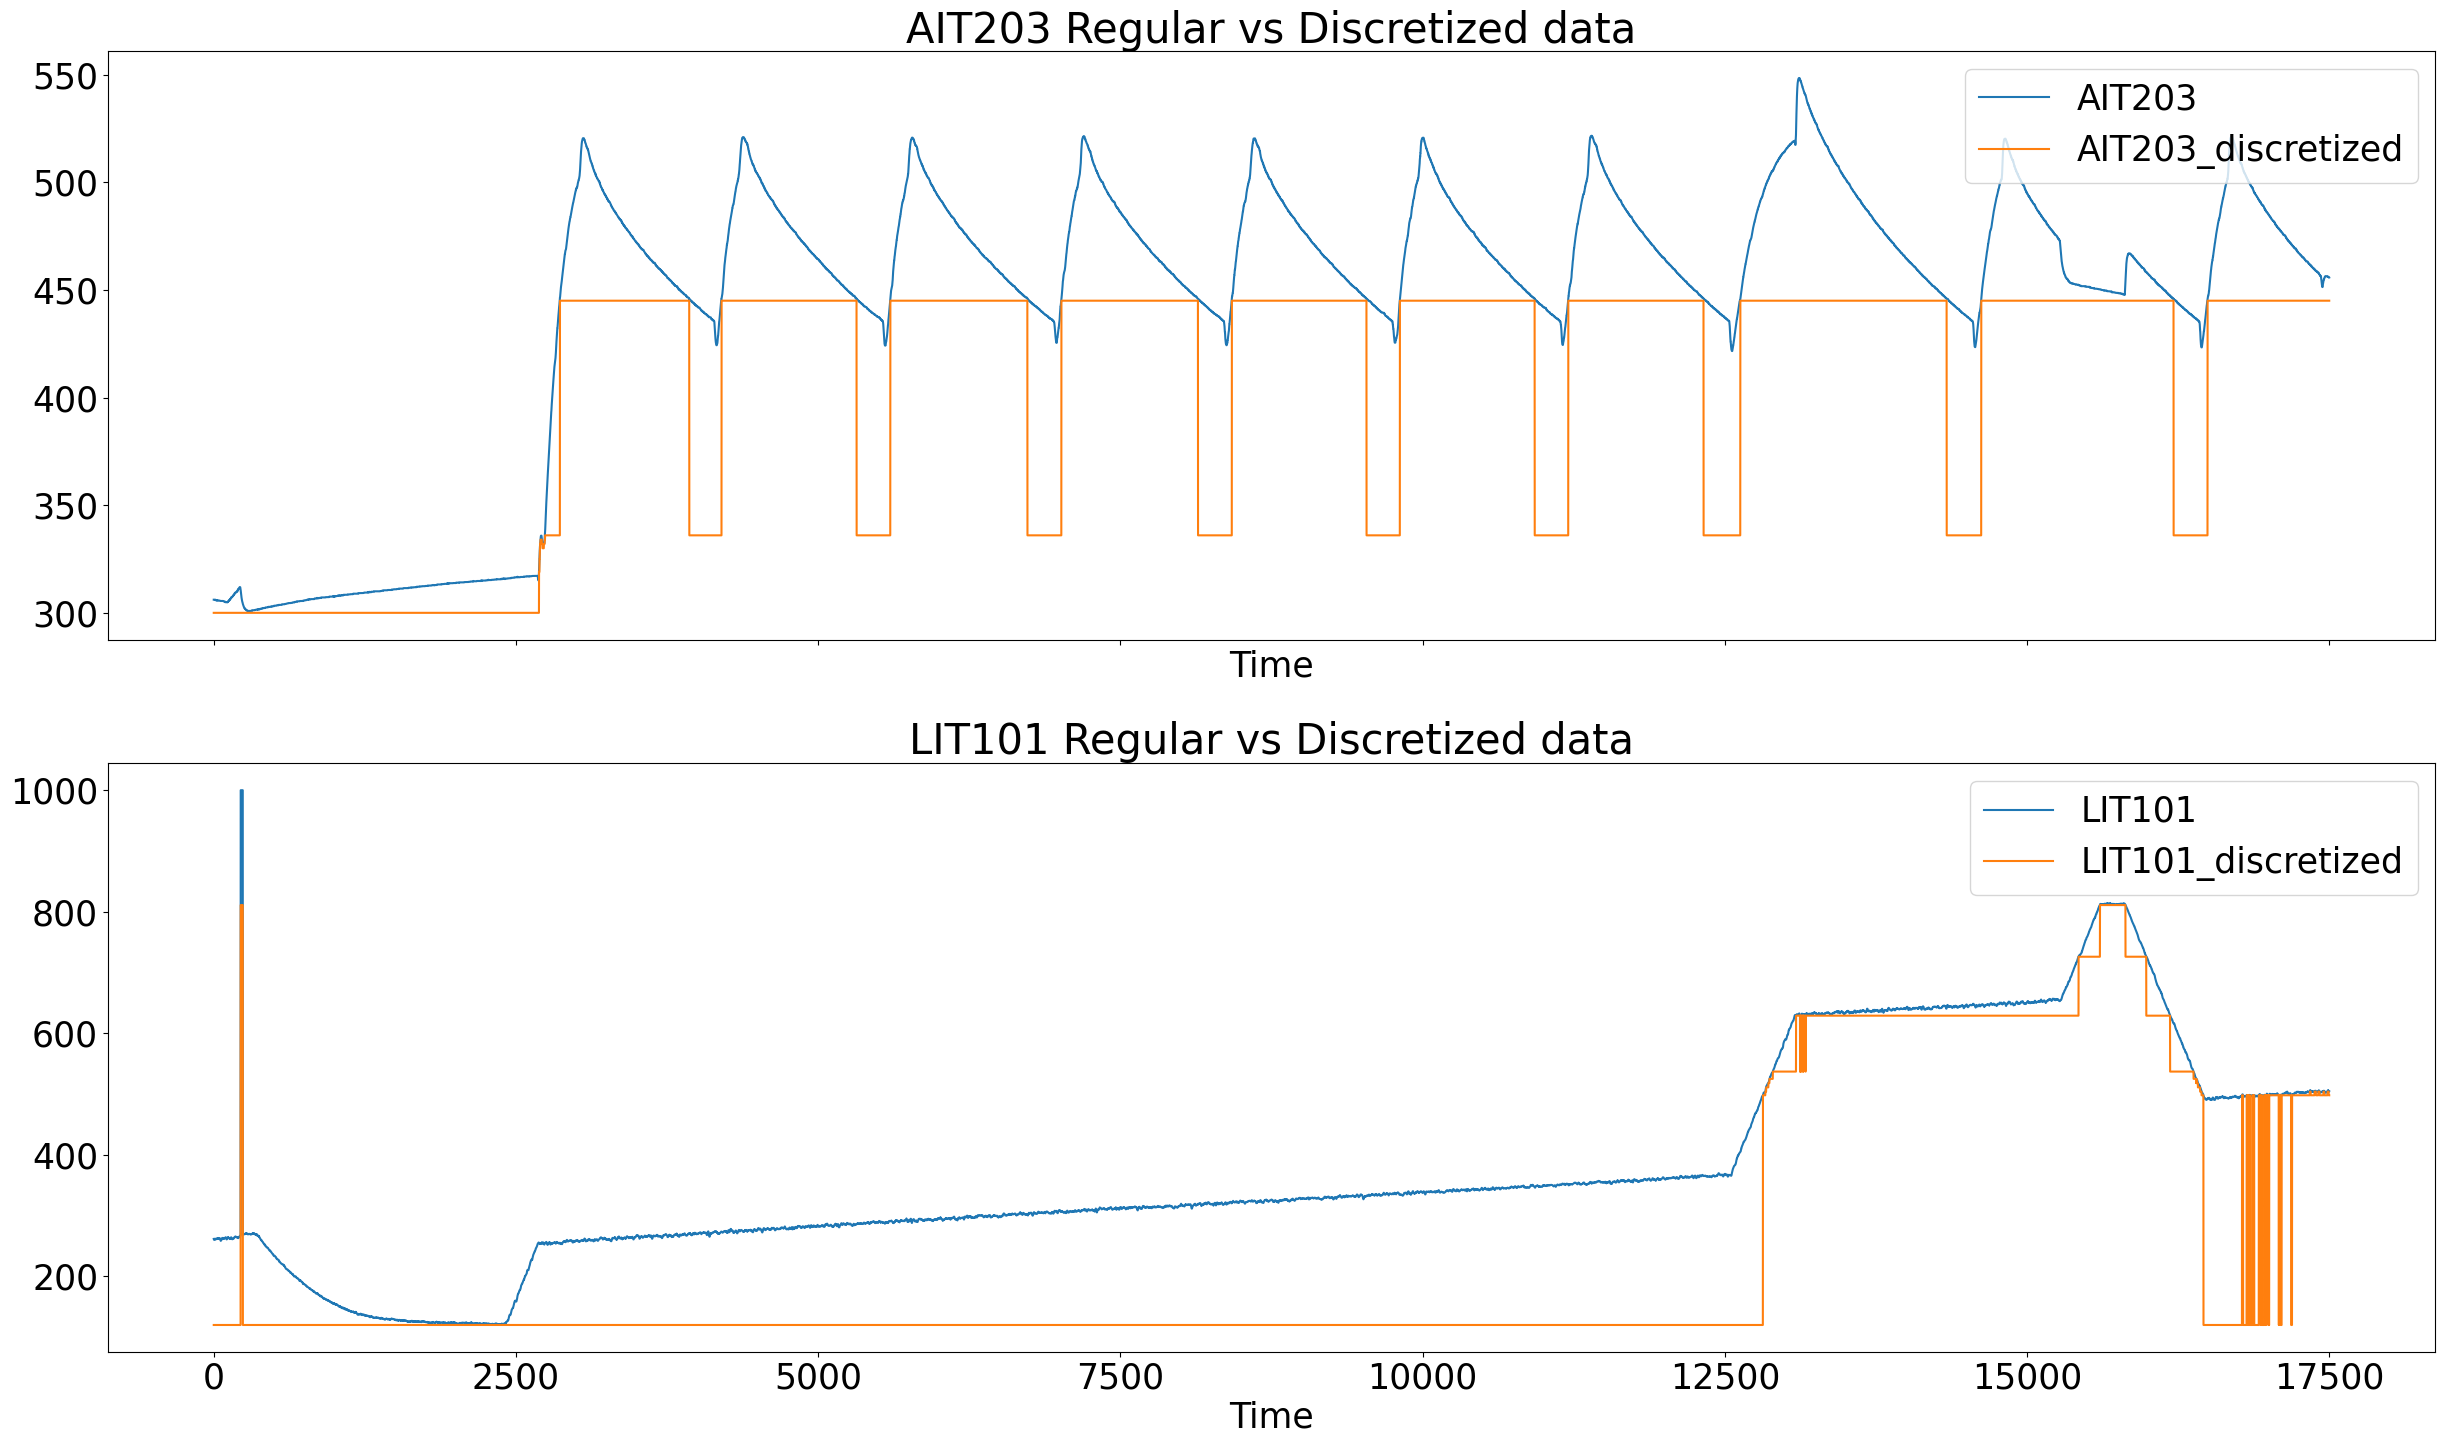

In [509]:
plt.clf()

time_max = 17_500

regular_columns = ["AIT203", "LIT101"]
discretised_columns = ["AIT203_discretized", "LIT101_discretized"]

fig, axes = plt.subplots(2, 1, figsize=(25, 15), sharex=True)
for i, ax in enumerate(axes.flatten()):
    ax.plot(df[regular_columns[i]].to_numpy()[:time_max])
    ax.plot(discretized_df[discretised_columns[i]].to_numpy()[:time_max])
    ax.set_title(f'{regular_columns[i]} Regular vs Discretized data')
    ax.set_xlabel('Time')
    ax.legend(labels=[regular_columns[i], discretised_columns[i]], loc='upper right')
plt.tight_layout()
plt.show()

#### N-grams

In [510]:
def build_n_grams_with_count(data, window_length, window_step=1, count=True):
    ngrams = [] if count else set()
    for i in range(0, data.shape[0] - window_length, window_step):
        window = str(data[i:i+window_length])
        if count:
            ngrams.append(window)
        else:
            ngrams.add(window)
    if count:
        ngram_counter = Counter(ngrams)
        return ngram_counter
    return set(ngrams)

In [511]:
discretized_data_ait = discretized_df['AIT203_discretized'].to_numpy()[:time_max]
discretized_data_lit = discretized_df['LIT101_discretized'].to_numpy()[:time_max]

In [512]:
ait_3gram = build_n_grams_with_count(discretized_data_ait, 3)
print("AIT203 3-grams count: ", len(ait_3gram))
ait_3gram

AIT203 3-grams count:  29


Counter({'[445. 445. 445.]': 12083,
         '[300. 300. 300.]': 2689,
         '[336. 336. 336.]': 2635,
         '[332. 332. 332.]': 10,
         '[334. 334. 334.]': 10,
         '[336. 336. 445.]': 10,
         '[336. 445. 445.]': 10,
         '[330. 330. 330.]': 9,
         '[445. 445. 336.]': 9,
         '[445. 336. 336.]': 9,
         '[319. 319. 319.]': 2,
         '[330. 332. 332.]': 2,
         '[332. 332. 334.]': 2,
         '[332. 334. 334.]': 2,
         '[300. 300. 319.]': 1,
         '[300. 319. 319.]': 1,
         '[319. 319. 325.]': 1,
         '[319. 325. 325.]': 1,
         '[325. 325. 328.]': 1,
         '[325. 328. 329.]': 1,
         '[328. 329. 330.]': 1,
         '[329. 330. 332.]': 1,
         '[334. 334. 332.]': 1,
         '[334. 332. 332.]': 1,
         '[332. 332. 330.]': 1,
         '[332. 330. 330.]': 1,
         '[330. 330. 332.]': 1,
         '[334. 334. 336.]': 1,
         '[334. 336. 336.]': 1})

In [513]:
lit_3gram = build_n_grams_with_count(discretized_data_lit, 3)
print("LIT101 3-grams count: ", len(lit_3gram))
lit_3gram

LIT101 3-grams count:  55


Counter({'[120. 120. 120.]': 13242,
         '[629. 629. 629.]': 2510,
         '[498. 498. 498.]': 500,
         '[537. 537. 537.]': 383,
         '[726. 726. 726.]': 345,
         '[811. 811. 811.]': 225,
         '[504. 504. 504.]': 49,
         '[525. 525. 525.]': 45,
         '[511. 511. 511.]': 32,
         '[120. 120. 498.]': 17,
         '[518. 518. 518.]': 17,
         '[120. 498. 498.]': 16,
         '[498. 120. 120.]': 16,
         '[498. 498. 120.]': 15,
         '[498. 498. 504.]': 6,
         '[498. 504. 504.]': 6,
         '[504. 504. 498.]': 6,
         '[504. 498. 498.]': 6,
         '[537. 629. 629.]': 5,
         '[629. 629. 537.]': 5,
         '[537. 537. 629.]': 4,
         '[629. 537. 537.]': 4,
         '[120. 498. 120.]': 4,
         '[629. 537. 629.]': 3,
         '[498. 120. 498.]': 3,
         '[518. 518. 525.]': 2,
         '[537. 629. 537.]': 2,
         '[525. 518. 518.]': 2,
         '[120. 120. 811.]': 1,
         '[120. 811. 811.]': 1,
         '[811. 8

In [514]:
def build_ngram_train_data(data, ngram_size, ngram_step, data_window_size, data_window_step):
    ngrams_names = build_n_grams_with_count(data, ngram_size, window_step=ngram_step, count=False)
    ngram_df_data = {key:[] for key in ngrams_names}

    for i in range(0, data.shape[0] - data_window_size, data_window_step):
        window = data[i:i+data_window_size]
        ngram_counter = build_n_grams_with_count(window, ngram_size, window_step=ngram_step)
        for n_gram in ngrams_names:
            if n_gram in ngram_counter:
                ngram_df_data[n_gram].append(ngram_counter[n_gram])
            else:
                ngram_df_data[n_gram].append(0)
        
    return pd.DataFrame(ngram_df_data)

In [515]:
discretized_data_ait = discretized_df['AIT203_discretized'].to_numpy()
occurrence_ait_df = build_ngram_train_data(discretized_data_ait, 3, 1, 100, 100)
occurrence_ait_df

,[328. 325. 325.],[445. 445. 336.],[328. 330. 332.],[329. 329. 330.],[332. 330. 330.],[325. 329. 330.],[330. 332. 330.],[319. 319. 325.],[325. 325. 328.],[332. 332. 330.],...,[325. 319. 319.],[445. 336. 336.],[328. 328. 328.],[328. 329. 329.],[325. 328. 329.],[325. 325. 325.],[336. 336. 336.],[325. 325. 319.],[329. 330. 332.],[330. 332. 334.]
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4962,0,0,0,0,0,0,0,0,0,0,...,0,0,97,0,0,0,0,0,0,0
4963,0,0,0,0,0,0,0,0,0,0,...,0,0,97,0,0,0,0,0,0,0
4964,0,0,0,0,0,0,0,0,0,0,...,0,0,97,0,0,0,0,0,0,0
4965,0,0,0,0,0,0,0,0,0,0,...,0,0,97,0,0,0,0,0,0,0


In [516]:
discretized_data_lit = discretized_df['LIT101_discretized'].to_numpy()
occurrence_lit_df = build_ngram_train_data(discretized_data_lit, 3, 1, 100, 100)
occurrence_lit_df

,[811. 120. 120.],[537. 537. 629.],[498. 120. 120.],[811. 726. 726.],[120. 120. 120.],[511. 504. 511.],[518. 518. 525.],[525. 537. 537.],[518. 518. 511.],[518. 525. 518.],...,[498. 504. 504.],[811. 726. 811.],[120. 120. 498.],[726. 629. 726.],[120. 498. 120.],[504. 504. 504.],[726. 811. 811.],[726. 811. 726.],[811. 811. 726.],[726. 629. 629.]
0,0,0,0,0,97,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,97,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,77,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,97,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,97,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4962,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,7,0,0,0,0
4963,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4964,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4965,0,0,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0


In [517]:
def train_ngram_nn(data, k=1):
    nbrs = NearestNeighbors(n_neighbors=k, metric='cosine')
    nbrs.fit(data)
    residuals, _ = nbrs.kneighbors(data)
    return np.mean(residuals, axis=1)

In [518]:
# Picked k from LOF analysis
picked_k = 51

residuals_ait = train_ngram_nn(occurrence_ait_df, k=picked_k)
residuals_lit = train_ngram_nn(occurrence_lit_df, k=picked_k)

residuals = [residuals_ait, residuals_lit]

<Figure size 640x480 with 0 Axes>

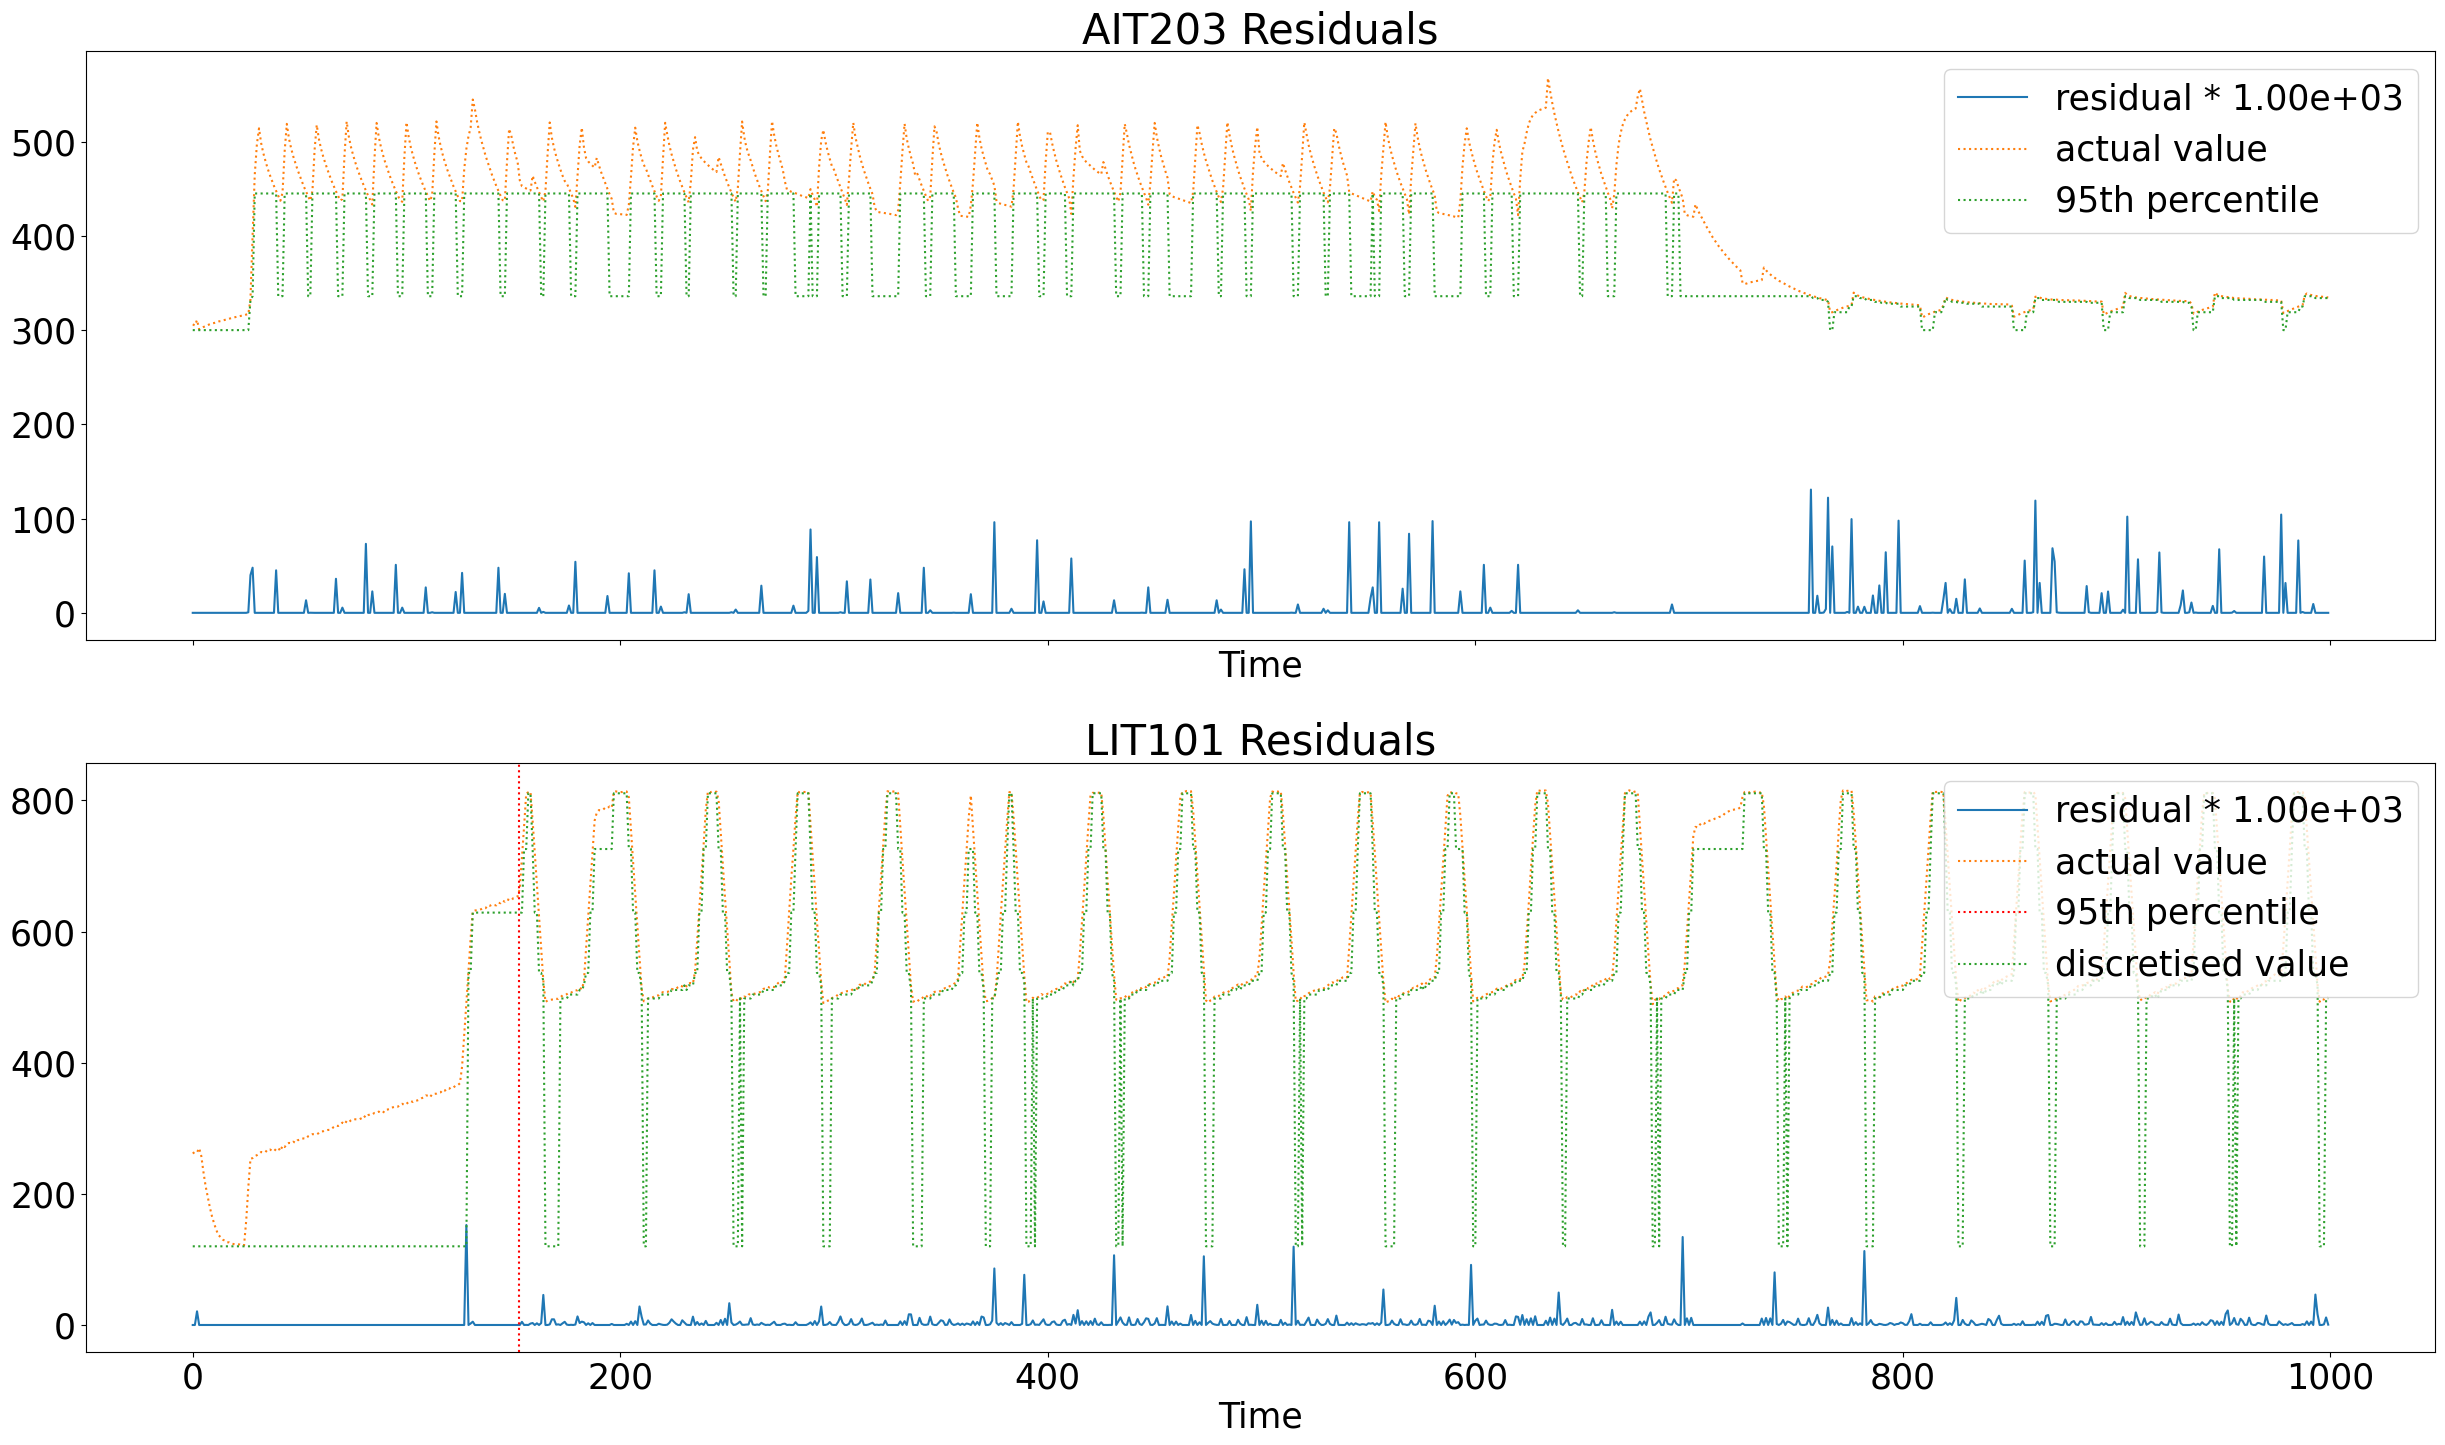

In [519]:
plt.clf()
max_time = 1000
power = 3
percentile = 0.95

regular_columns = ["AIT203", "LIT101"]
fig, axes = plt.subplots(2, 1, figsize=(25, 15), sharex=True)
for i, ax in enumerate(axes.flatten()):
    #Scaled residuals 10^power
    res = residuals[i] * pow(10, power)
    ax.plot(res[:max_time])
    
    #Sub-sampled values to fit residuals length
    values = df[regular_columns[i]].to_numpy()
    values = values[::len(values)//len(residuals[i])]
    ax.plot(values[:max_time], linestyle=':')
    
    #Anomalies through percentile
    pecentile_val = np.max(residuals[i]) * percentile * pow(10, power)
    for val in res[:max_time]:
        if val > pecentile_val:
            ax.axvline(np.max(val), color='r', linestyle=':')
    
    #Sub-sampled discretised values to fit residuals length
    values = disc_vals_df[discretised_columns[i]].to_numpy()
    values = values[::len(values)//len(residuals[i])]
    ax.plot(values[:max_time], linestyle=':')
    
    ax.set_title(f'{regular_columns[i]} Residuals')
    ax.legend(labels=[f"residual * {pow(10, power):.2e}", "actual value", f"{int(percentile*100)}th percentile", "discretised value"], loc='upper right')
    ax.set_xlabel('Time')

plt.tight_layout()
plt.show()

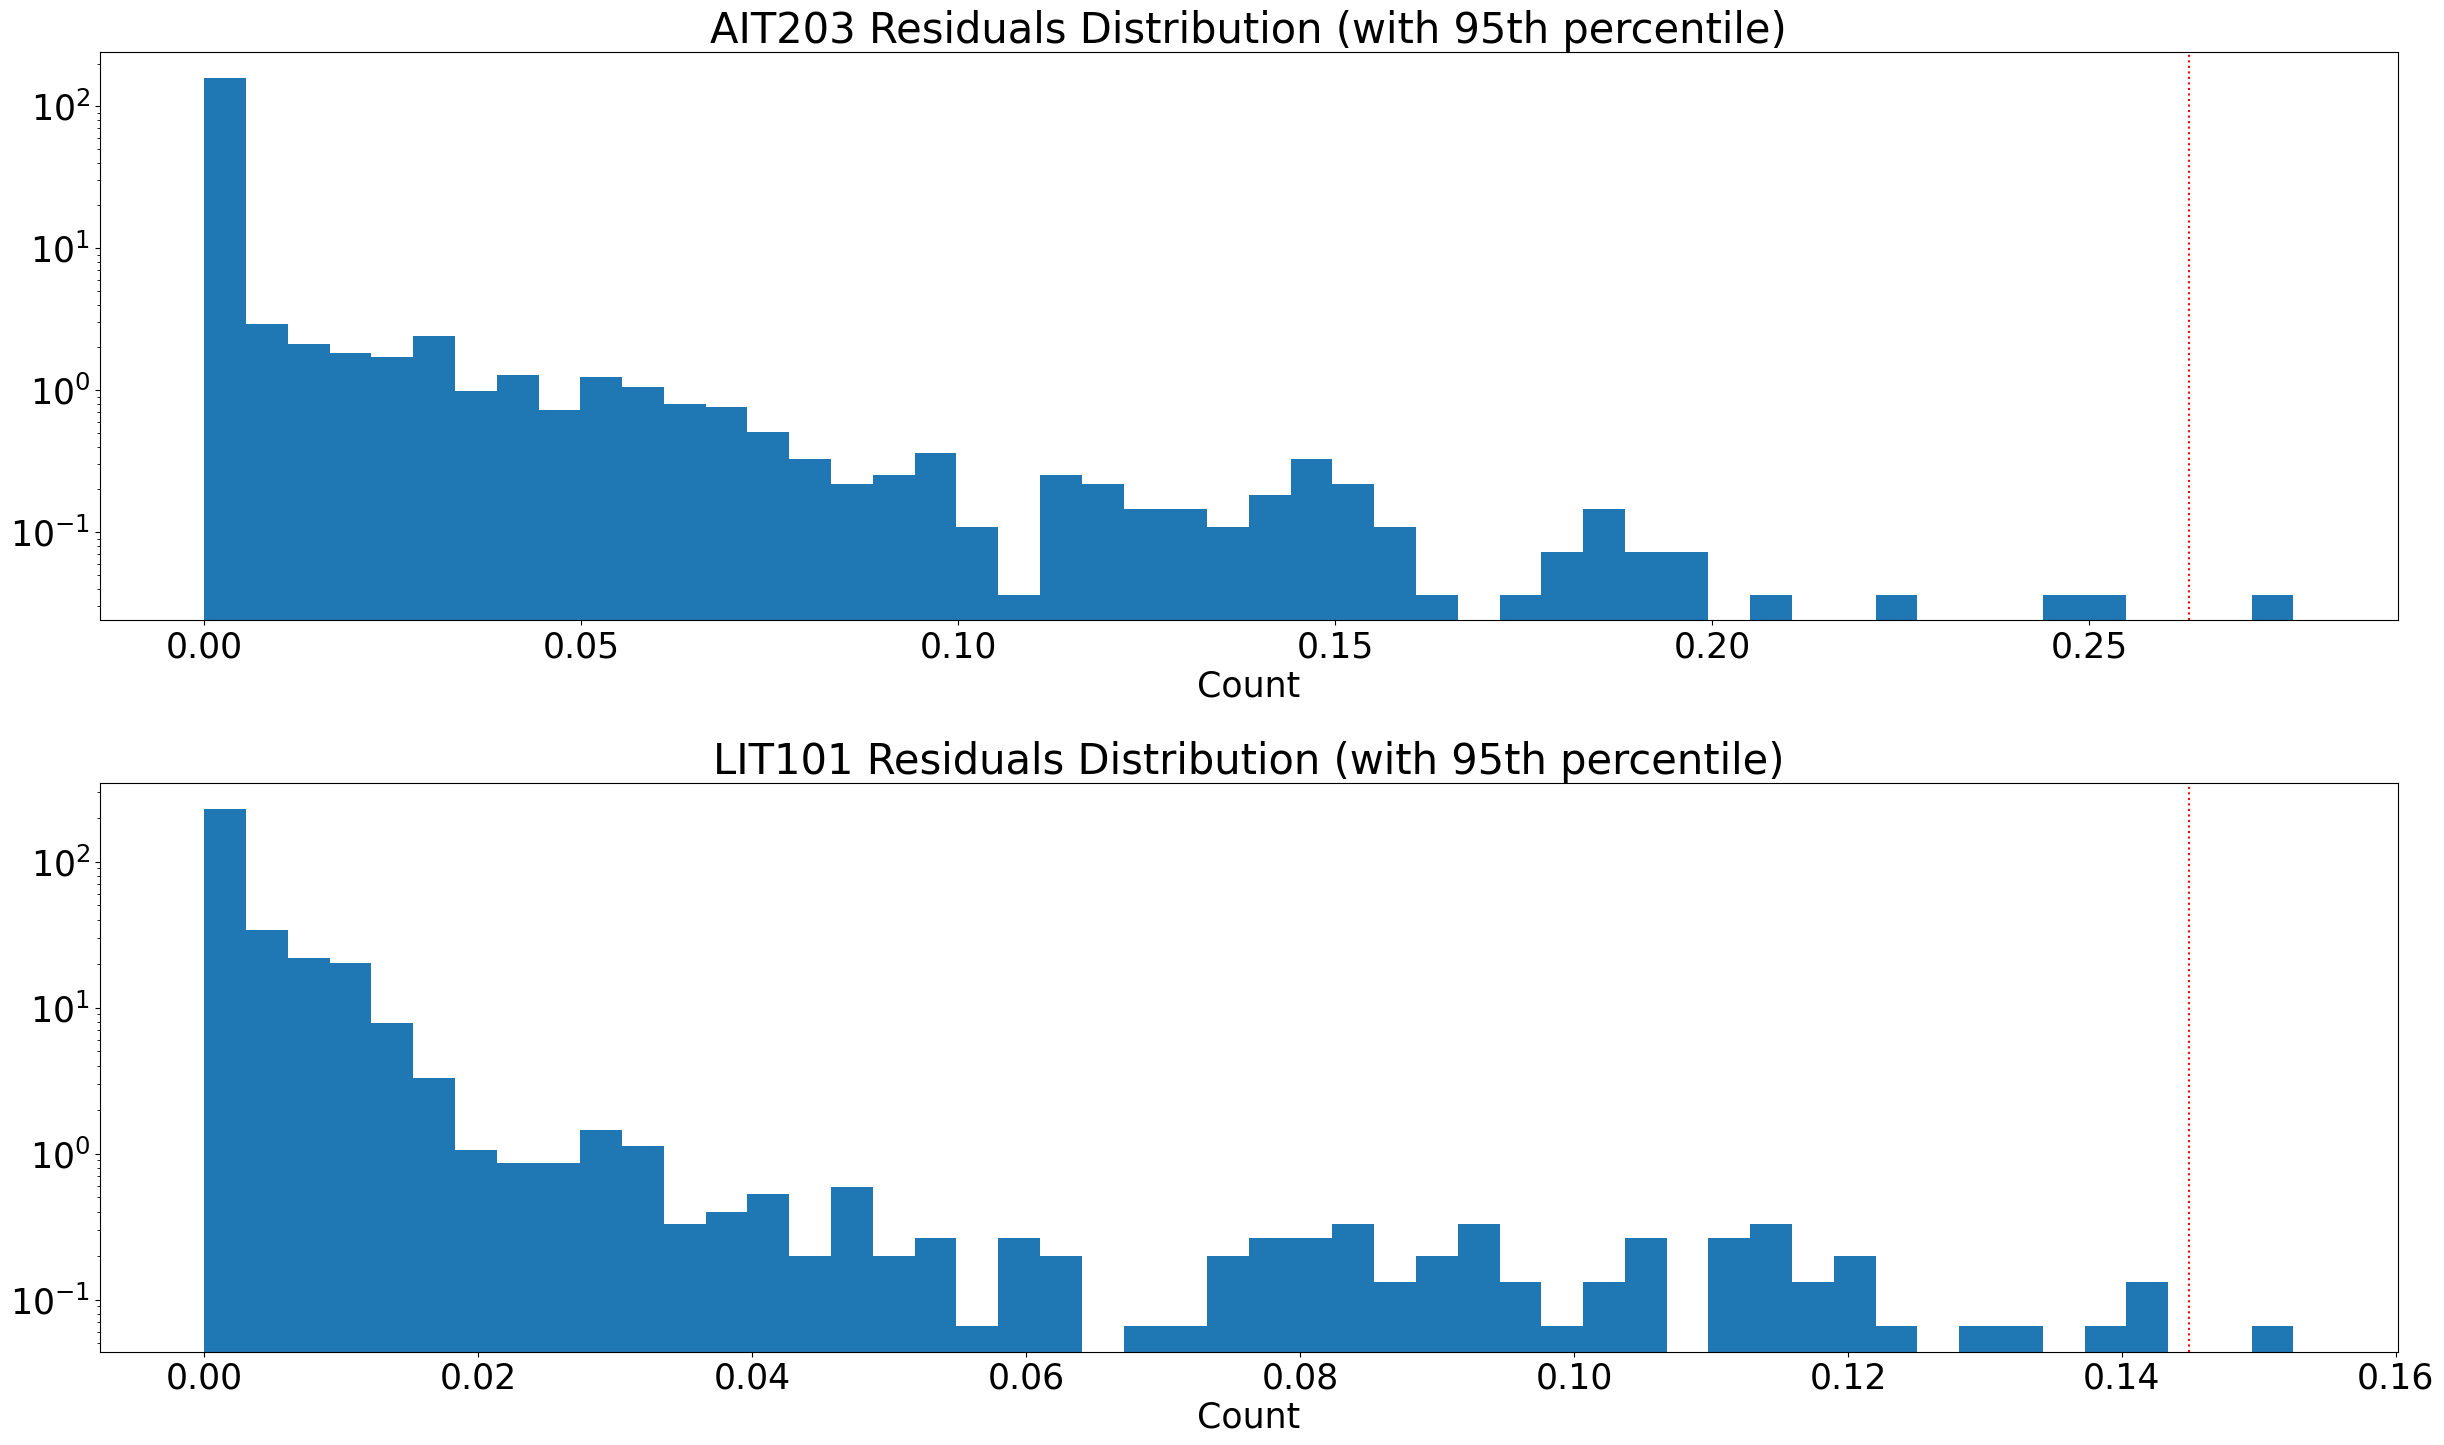

In [520]:
percentile = 0.95

fig, axes = plt.subplots(2, 1, figsize=(25, 15))
for i, ax in enumerate(axes.flatten()):
    ax.hist(residuals[i], density=True, bins=50)
    ax.axvline(np.max(residuals[i]) * percentile, color='r', linestyle=':', label=f"{int(percentile*100)}th percentile")
    ax.set_title(f'{regular_columns[i]} Residuals Distribution (with {int(percentile*100)}th percentile)')
    ax.set_xlabel('Residual')
    ax.set_xlabel('Count')
    ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [521]:
percentile = 0.95
pecentile_ait_val = np.max(residuals_ait) * percentile
pecentile_lit_val = np.max(residuals_lit) * percentile

discretized_data_ait = discretized_data(val_data_df[["AIT203"]].to_numpy())
discretized_data_lit = discretized_data(val_data_df[["LIT101"]].to_numpy())

occurrence_ait_df = build_ngram_train_data(discretized_data_ait, 3, 1, 100, 100)
occurrence_lit_df = build_ngram_train_data(discretized_data_lit, 3, 1, 100, 100)

picked_k = 51

residuals_ait = train_ngram_nn(occurrence_ait_df, k=picked_k)
residuals_lit = train_ngram_nn(occurrence_lit_df, k=picked_k)


labels = val_data_df[["Label"]].to_numpy()
val_anomalies_ait_pred = find_anomalies(residuals_ait, pecentile_ait_val)
val_anomalies_lit_pred = find_anomalies(residuals_lit, pecentile_lit_val)


/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [522]:
tp, fp, tn, fn = calculate_statistics(val_anomalies_ait_pred, labels)
print(f"True positives: {tp}\nFalse positives: {fp}\nTrue negatives: {tn}\nFalse negatives: {fn}")
print("--------------------------------------")
accuracy, precision, recall, f1_score = calculate_metrics(tp, fp, tn, fn)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1_score}")

True positives: 66216
False positives: 1283538
True negatives: 479829289
False negatives: 24753748
--------------------------------------
Accuracy: 0.9485360773937264
Precision: 0.04905782831538191
Recall: 0.0026678523788350376
F1 score: 0.0050605054284497825


In [523]:
tp, fp, tn, fn = calculate_statistics(val_anomalies_lit_pred, labels)
print(f"True positives: {tp}\nFalse positives: {fp}\nTrue negatives: {tn}\nFalse negatives: {fn}")
print("--------------------------------------")
accuracy, precision, recall, f1_score = calculate_metrics(tp, fp, tn, fn)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1_score}")

True positives: 88288
False positives: 1711384
True negatives: 479401443
False negatives: 24731676
--------------------------------------
Accuracy: 0.9477340459634291
Precision: 0.04905782831538191
Recall: 0.0035571365051133837
F1 score: 0.006633298817459412


#### Differencing sensor data

In [524]:
# Convert date_column to DateTime format
train_data_df['Timestamp'] = pd.to_datetime(train_data_df['Timestamp'])

# Sort DataFrame by date_column
df = train_data_df.sort_values('Timestamp')

# Select columns to discretize
columns_to_discretize = ["AIT203", "LIT101"]

ait_data = np.squeeze(df[["AIT203"]].to_numpy())
ait_data = np.diff(ait_data)

lit_data = np.squeeze(df[["LIT101"]].to_numpy())
lit_data = np.diff(lit_data)

<Figure size 640x480 with 0 Axes>

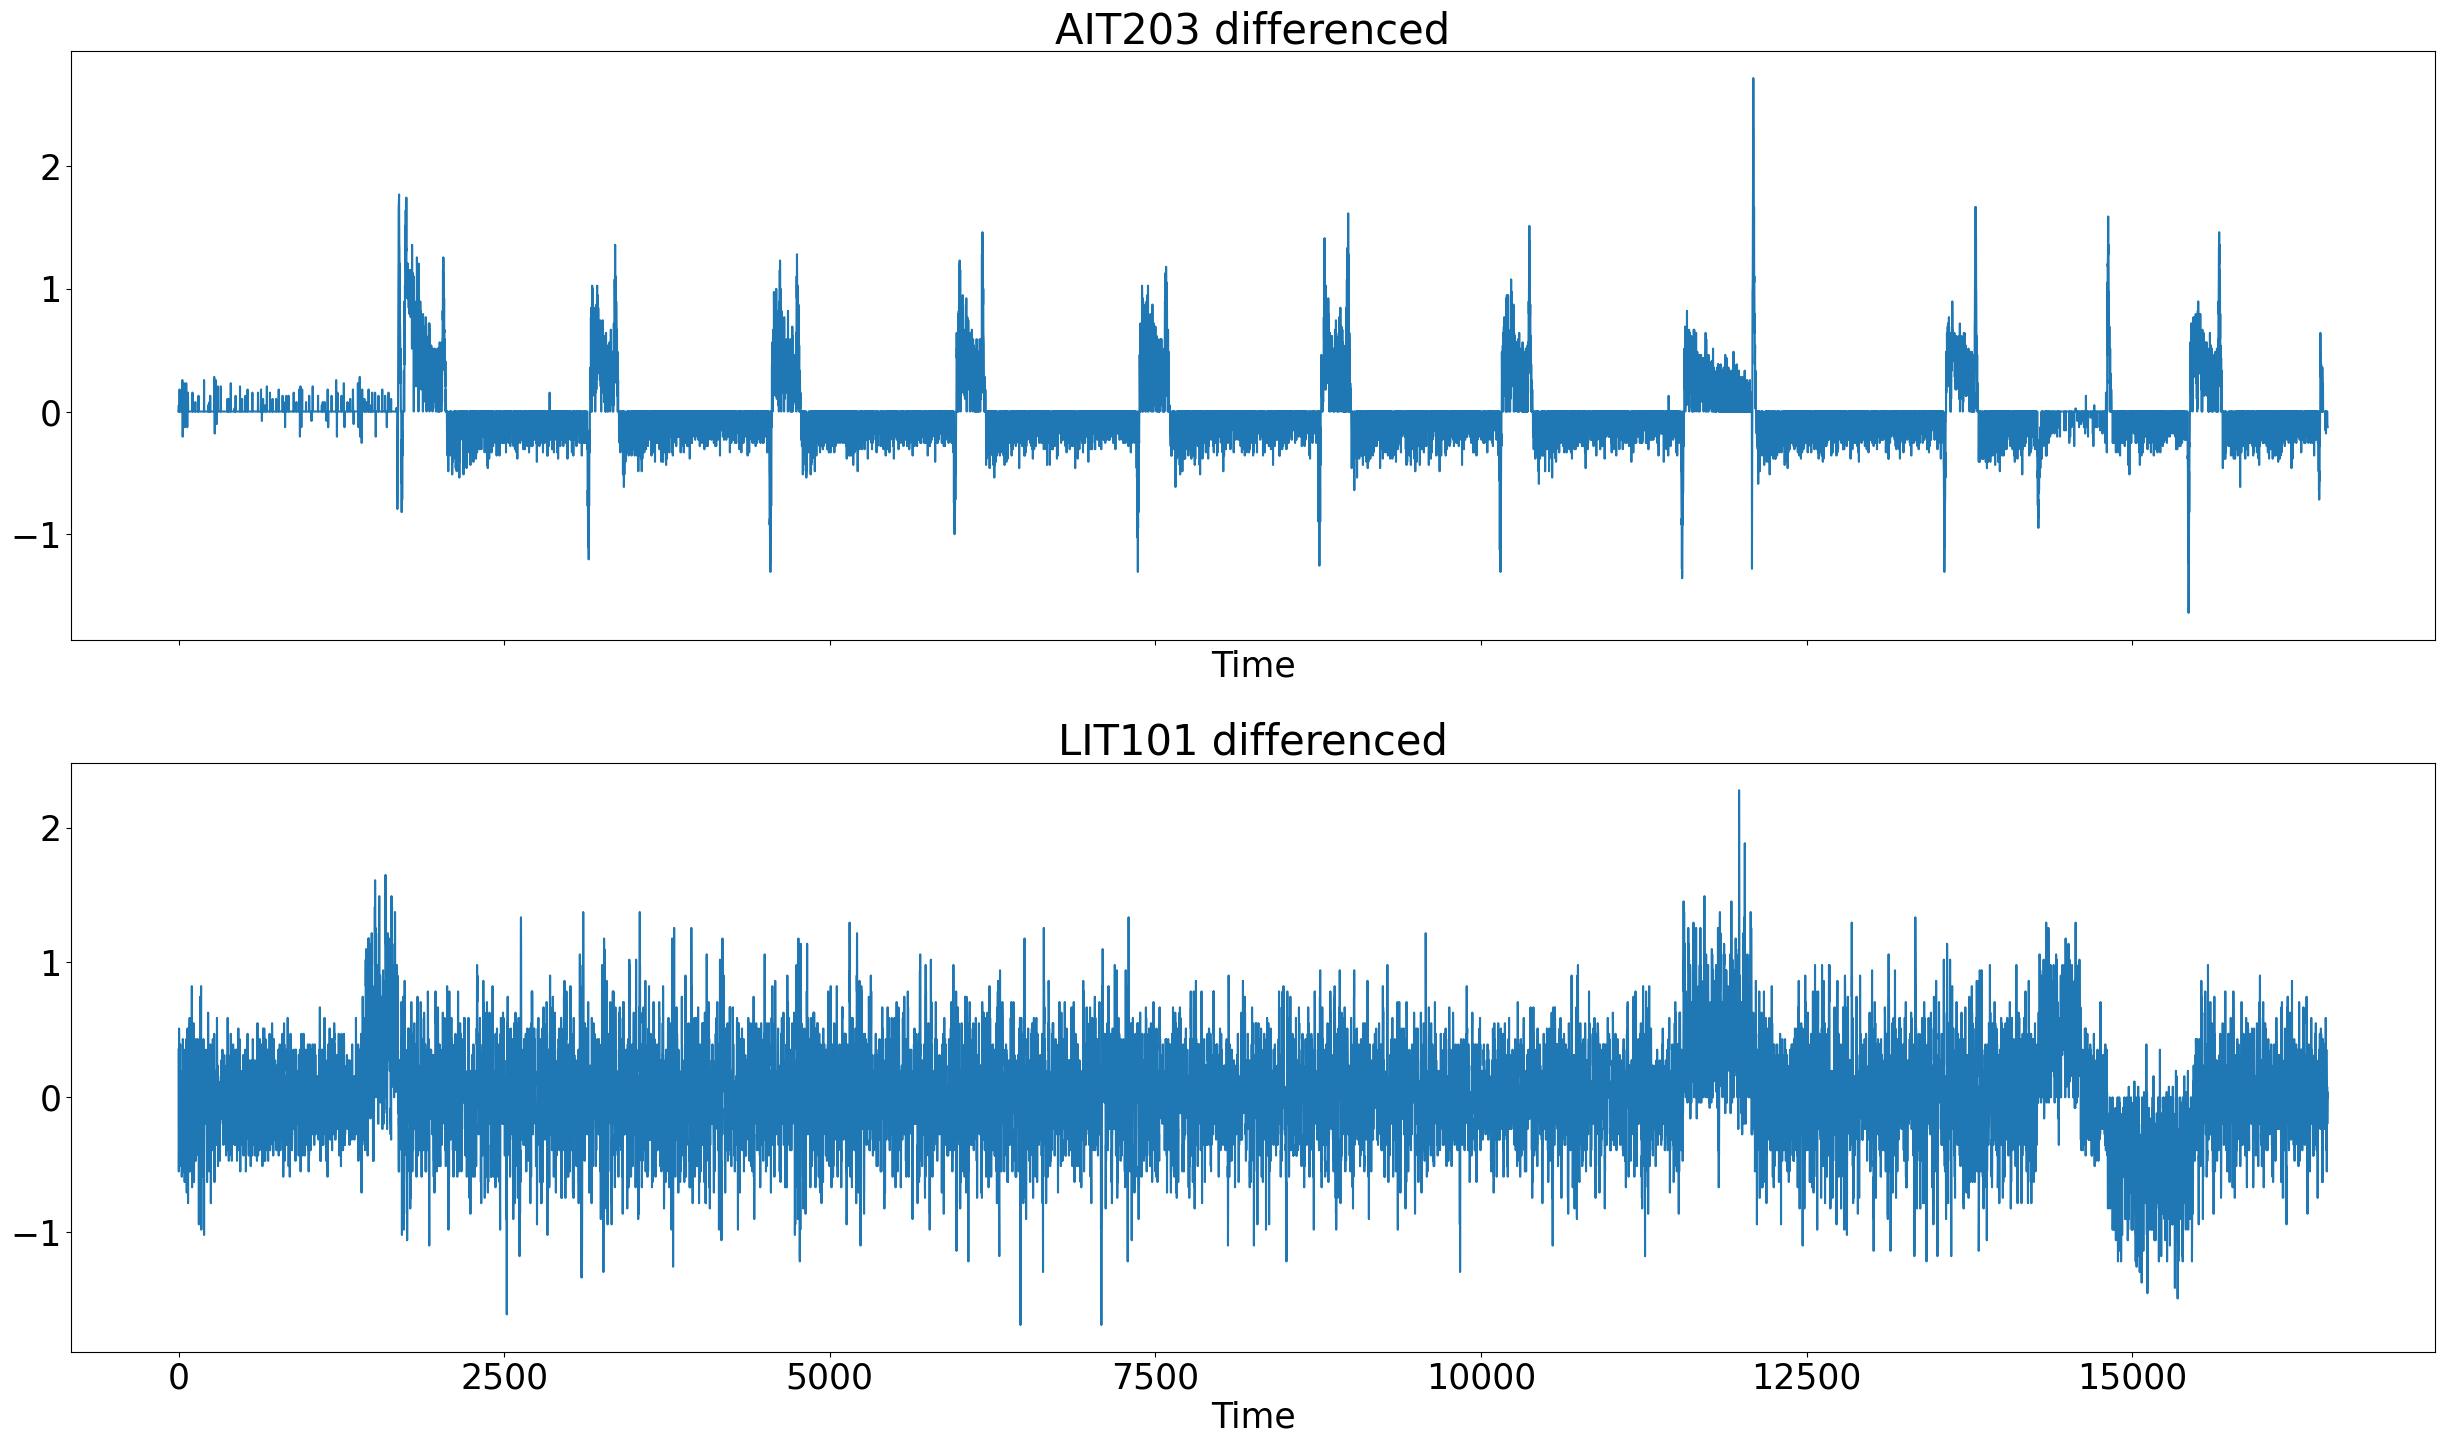

In [525]:
plt.clf()
time_start = 1_000
time_max = 17_500

diff_data = [ait_data, lit_data]

fig, axes = plt.subplots(2, 1, figsize=(25, 15), sharex=True)
for i, ax in enumerate(axes.flatten()):
    ax.plot(diff_data[i][time_start:time_max])
    ax.set_title(f'{columns_to_discretize[i]} differenced')
    ax.set_xlabel('Time')
plt.tight_layout()
plt.show()

In [526]:
# Initialize the discretizer
n_bins = 20_000

discretized_data_ait = discretized_data(ait_data.reshape(-1, 1), n_bins=n_bins)
discretized_data_lit = discretized_data(lit_data.reshape(-1, 1), n_bins=n_bins)

disretized_data = np.concatenate((discretized_data_ait, discretized_data_lit), axis=1)


discretized_df = pd.DataFrame(
    disretized_data,
    columns=[
        'AIT203_percentile',
        'AIT203_discretized',
        'LIT101_percentile',
        'LIT101_discretized'
    ]
)
discretized_df

/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed.

,AIT203_percentile,AIT203_discretized,LIT101_percentile,LIT101_discretized
0,72.0,0.0,80.0,0.0
1,72.0,0.0,87.0,0.0
2,72.0,0.0,62.0,0.0
3,72.0,0.0,80.0,0.0
4,72.0,0.0,115.0,0.0
...,...,...,...,...
496794,72.0,0.0,100.0,0.0
496795,72.0,0.0,100.0,0.0
496796,83.0,0.0,100.0,0.0
496797,72.0,0.0,106.0,0.0


<Figure size 640x480 with 0 Axes>

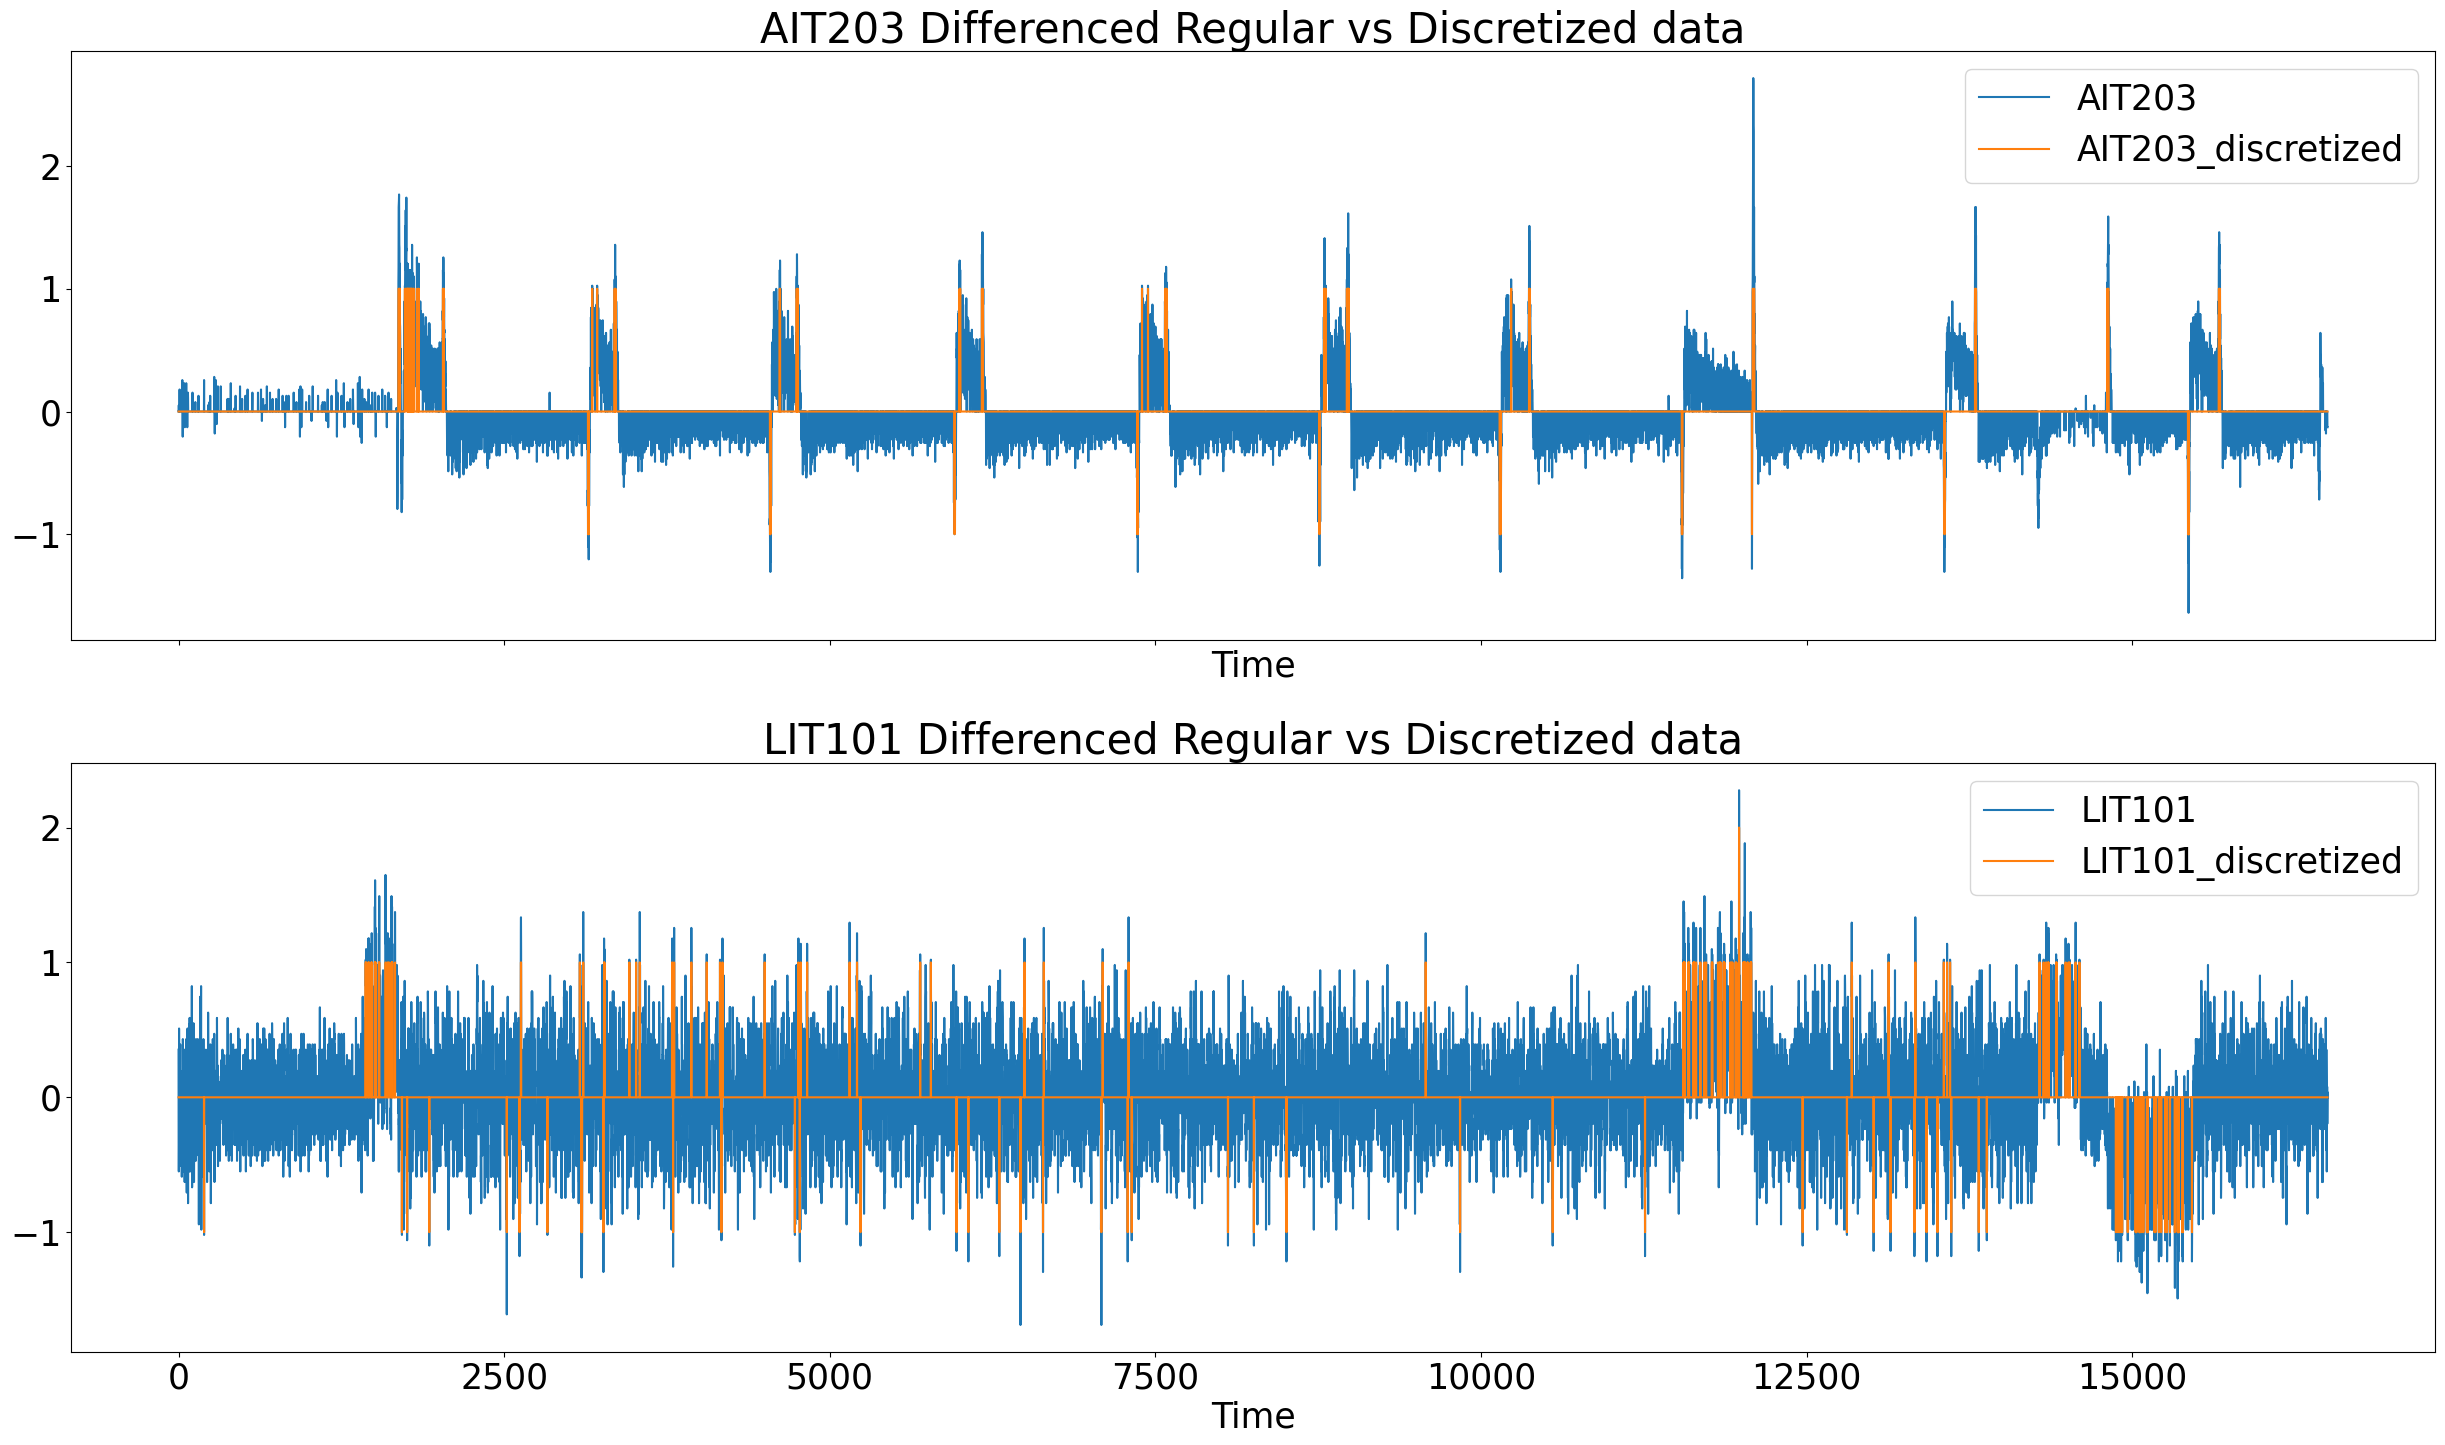

In [527]:
plt.clf()
time_start = 1_000
time_max = 17_500

diff_data = [ait_data, lit_data]

regular_columns = ["AIT203", "LIT101"]
discretised_columns = ["AIT203_discretized", "LIT101_discretized"]

fig, axes = plt.subplots(2, 1, figsize=(25, 15), sharex=True)
for i, ax in enumerate(axes.flatten()):
    ax.plot(diff_data[i][time_start:time_max])
    ax.plot(discretized_df[discretised_columns[i]].to_numpy()[time_start:time_max])
    ax.set_title(f'{regular_columns[i]} Differenced Regular vs Discretized data')
    ax.set_xlabel('Time')
    ax.legend(labels=[regular_columns[i], discretised_columns[i]], loc='upper right')
plt.tight_layout()
plt.show()

In [528]:
discretized_data_ait = discretized_df['AIT203_discretized'].to_numpy()
occurrence_ait_df = build_ngram_train_data(discretized_data_ait, 3, 1, 100, 100)

discretized_data_lit = discretized_df['LIT101_discretized'].to_numpy()
occurrence_lit_df = build_ngram_train_data(discretized_data_lit, 3, 1, 100, 100)

# Picked k from LOF analysis
picked_k = 51

residuals_ait = train_ngram_nn(occurrence_ait_df, k=picked_k)
residuals_lit = train_ngram_nn(occurrence_lit_df, k=picked_k)

residuals = [residuals_ait, residuals_lit]

<Figure size 640x480 with 0 Axes>

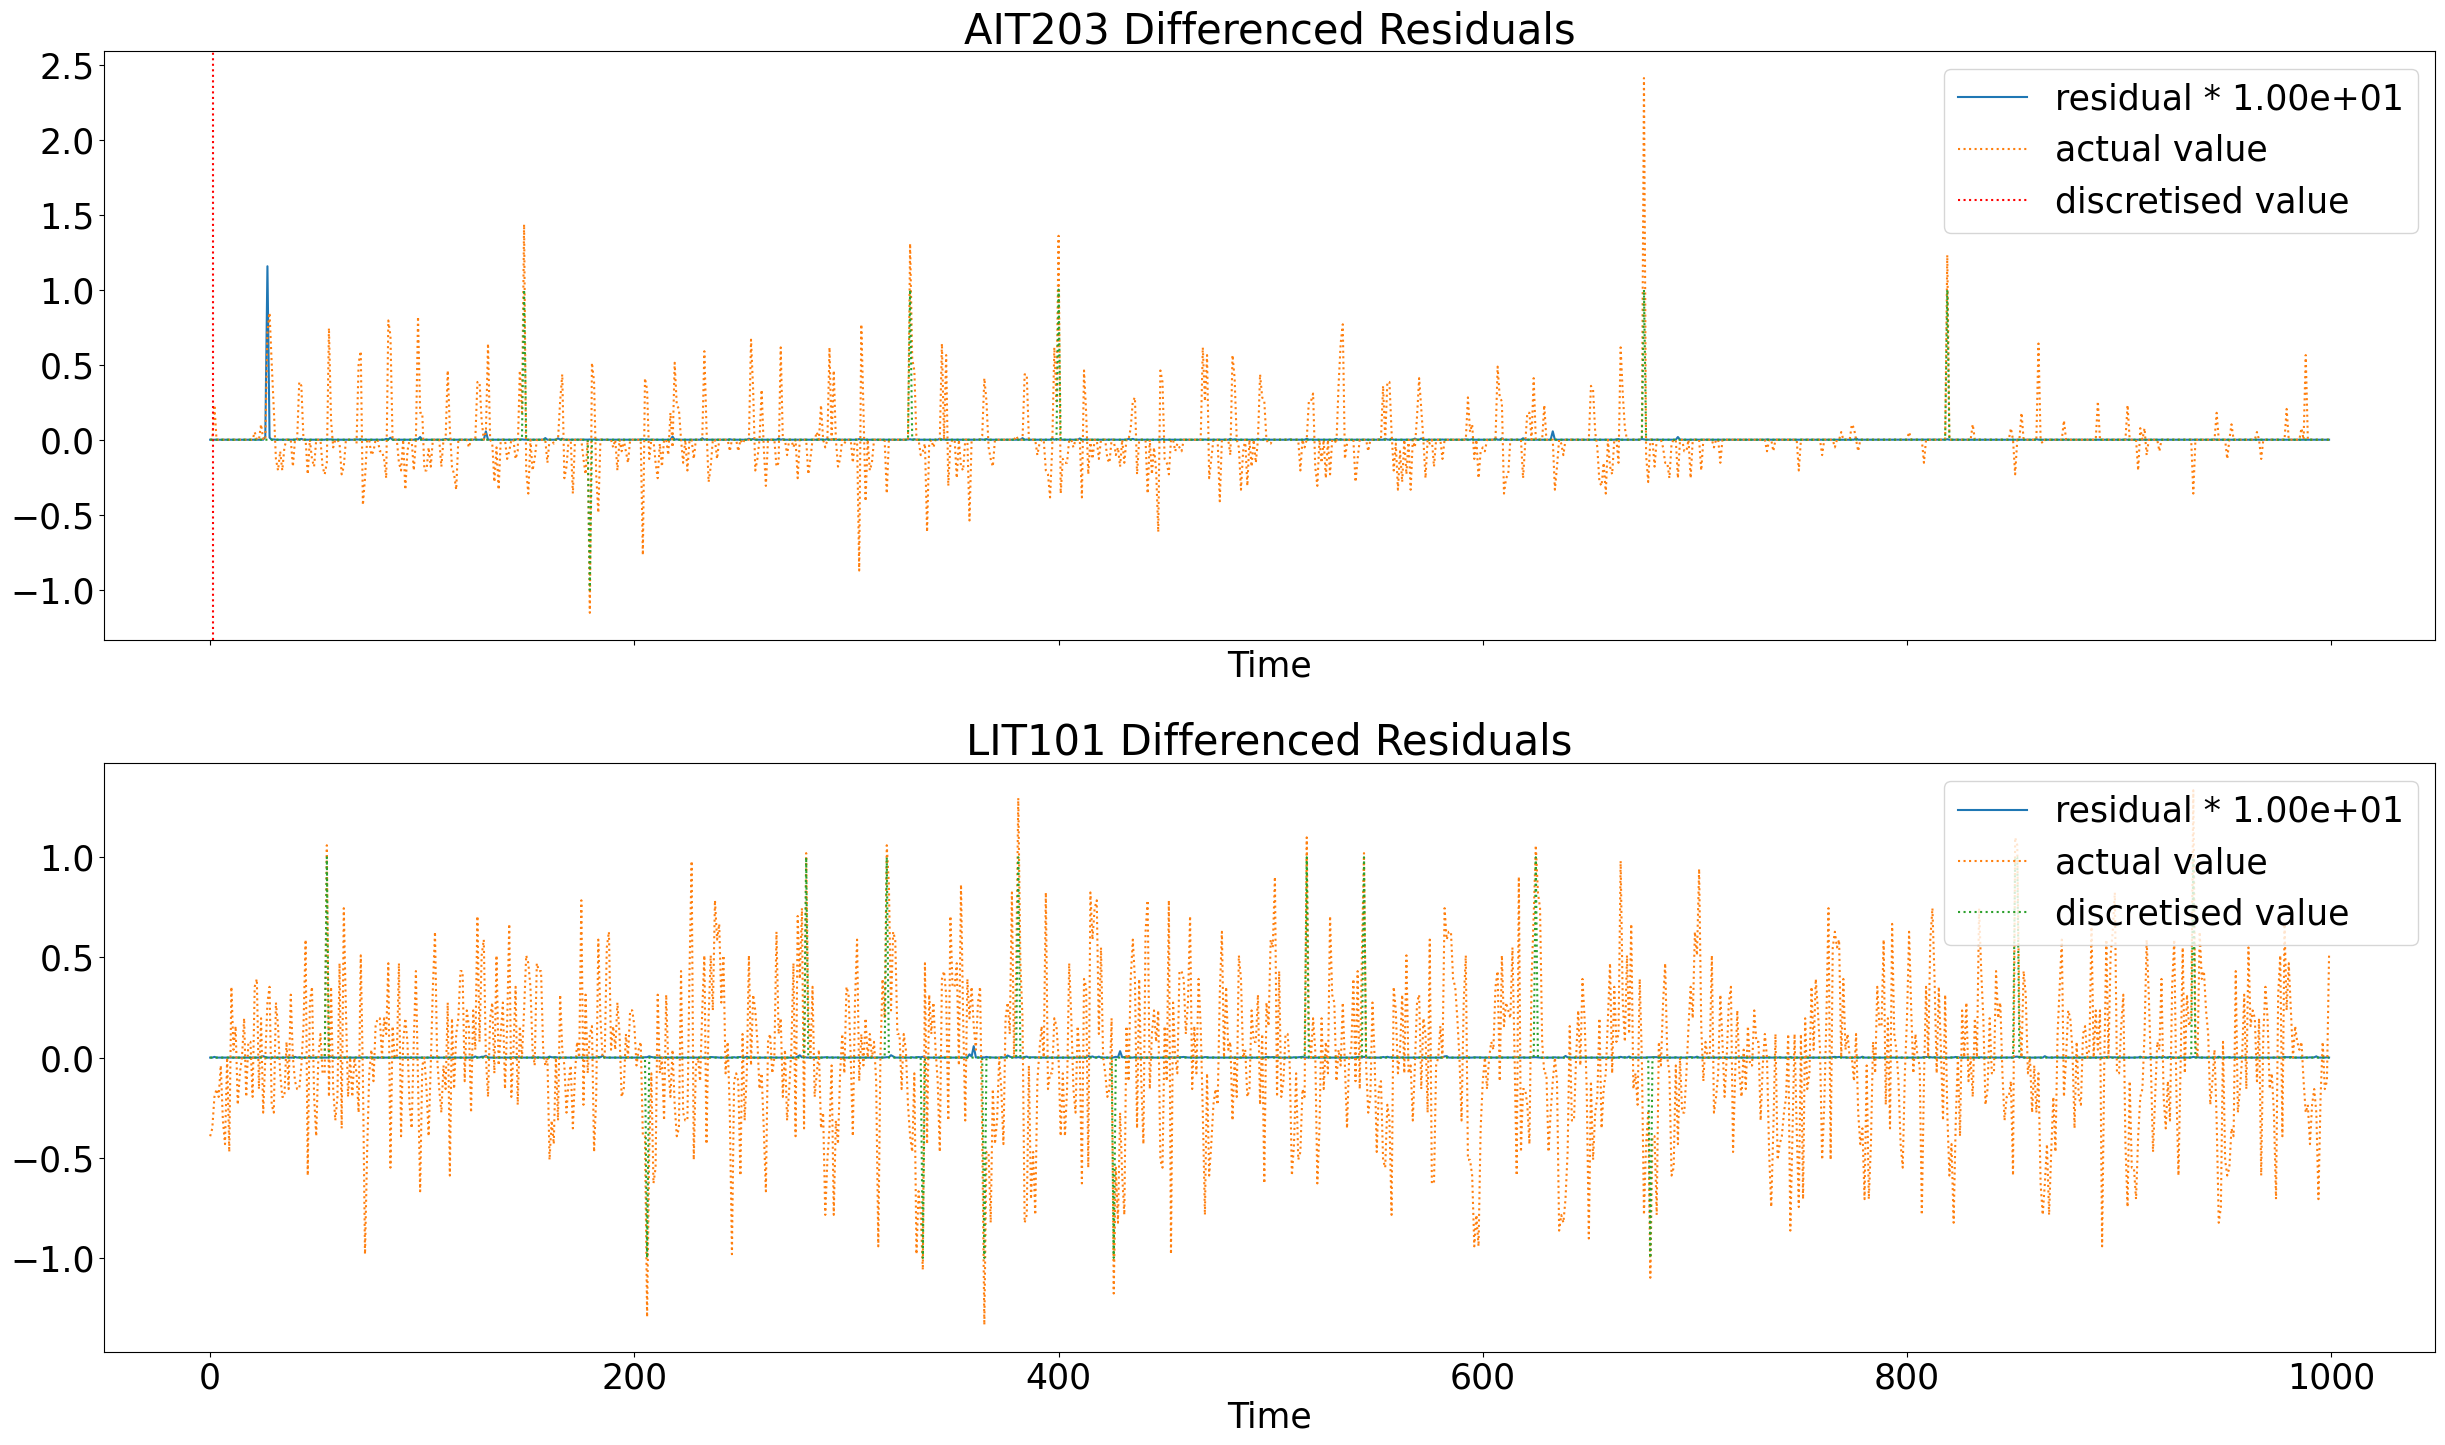

In [529]:
plt.clf()

time_start = 0
time_max = 1_000
percentile = 0.95
power = 1

diff_data = [ait_data, lit_data]

regular_columns = ["AIT203", "LIT101"]
fig, axes = plt.subplots(2, 1, figsize=(25, 15), sharex=True)
for i, ax in enumerate(axes.flatten()):
    #Scaled residuals 10^power
    res = residuals[i] * pow(10, power)
    ax.plot(res[time_start:time_max])
    
    #Sub-sampled values to fit residuals length
    values = diff_data[i]
    values = values[::len(values)//len(residuals[i])]
    ax.plot(values[time_start:time_max], linestyle=':')
    
    #Anomalies through percentile
    pecentile_val = np.max(residuals[i]) * percentile
    for val in res[:max_time]:
        if val > pecentile_val * pow(10, power):
            ax.axvline(np.max(val), color='r', linestyle=':')
    
    #Sub-sampled discretised values to fit residuals length
    values = discretized_df[discretised_columns[i]].to_numpy()
    values = values[::len(values)//len(residuals[i])]
    ax.plot(values[time_start:time_max], linestyle=':')
    
    ax.set_title(f'{regular_columns[i]} Differenced Residuals')
    ax.legend(labels=[f"residual * {pow(10, power):.2e}", "actual value", "discretised value"], loc='upper right')
    ax.set_xlabel('Time')
plt.tight_layout()
plt.show()

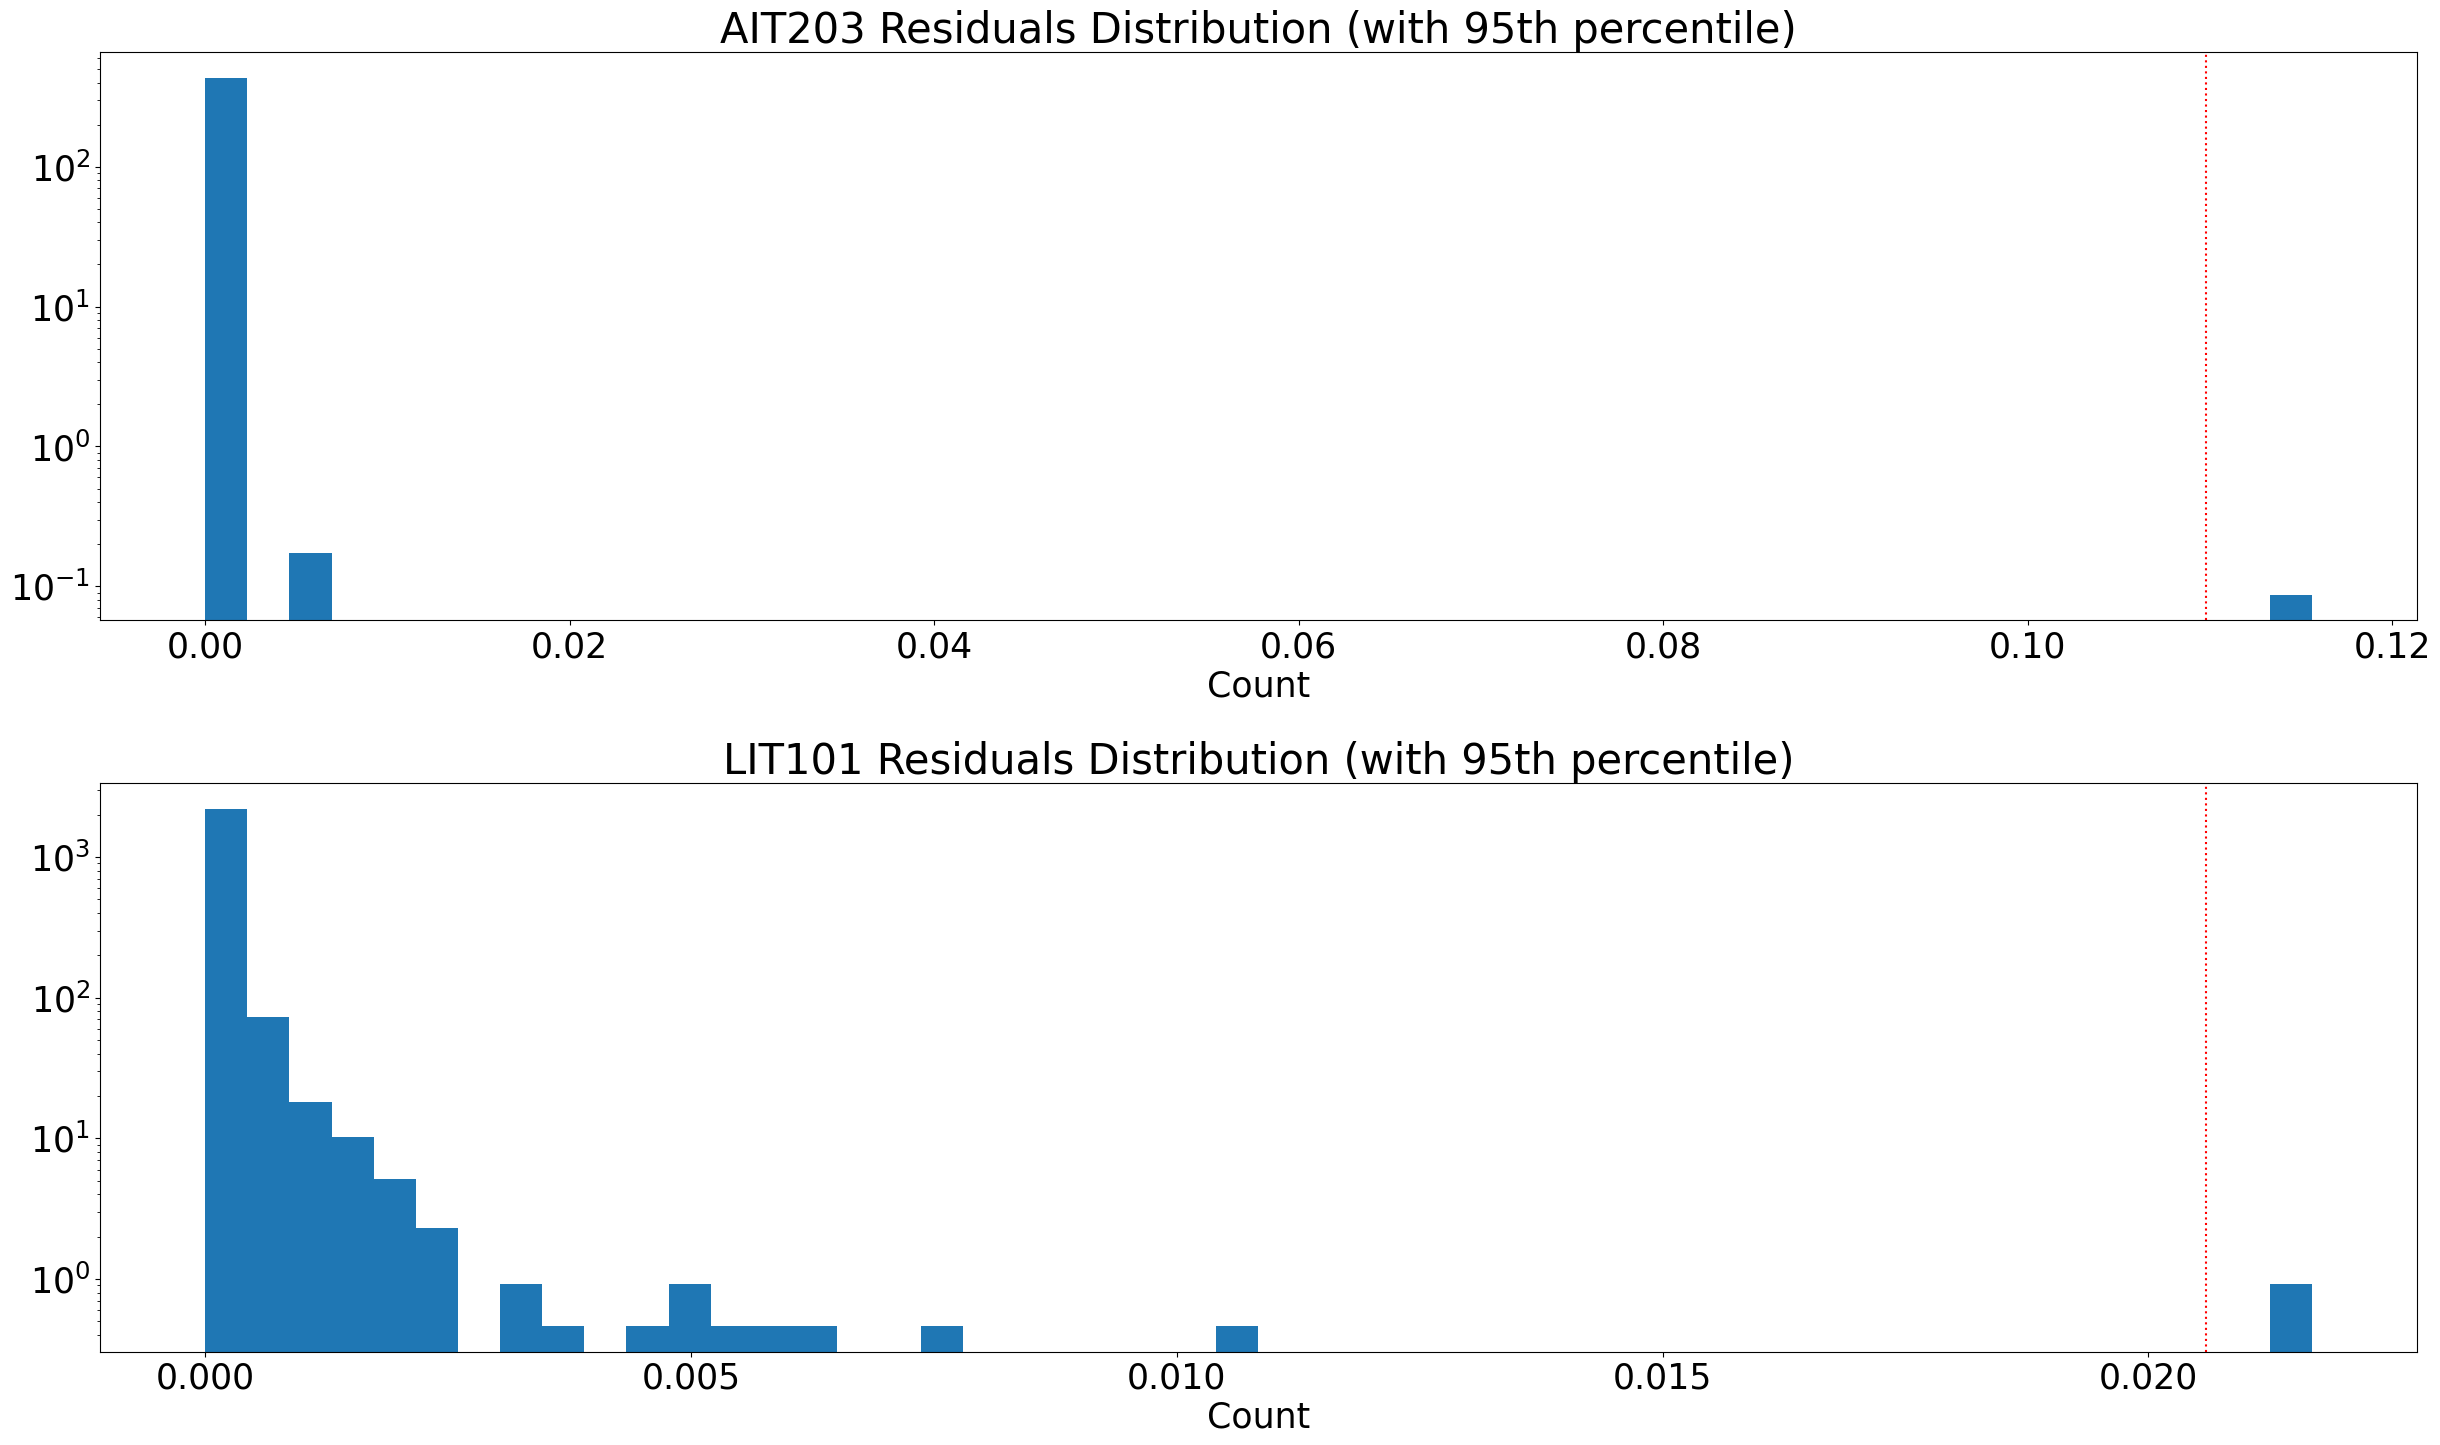

In [530]:
percentile = 0.95

fig, axes = plt.subplots(2, 1, figsize=(25, 15))
for i, ax in enumerate(axes.flatten()):
    ax.hist(residuals[i], density=True, bins=50)
    ax.axvline(np.max(residuals[i]) * percentile, color='r', linestyle=':', label=f"{int(percentile*100)}th percentile")
    ax.set_title(f'{regular_columns[i]} Residuals Distribution (with {int(percentile*100)}th percentile)')
    ax.set_xlabel('Residual')
    ax.set_xlabel('Count')
    ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [531]:
percentile = 0.95
pecentile_ait_val = np.max(residuals_ait) * percentile
pecentile_lit_val = np.max(residuals_lit) * percentile

discretized_data_ait = discretized_data(val_data_df[["AIT203"]].to_numpy())
discretized_data_lit = discretized_data(val_data_df[["LIT101"]].to_numpy())

occurrence_ait_df = build_ngram_train_data(discretized_data_ait, 3, 1, 100, 100)
occurrence_lit_df = build_ngram_train_data(discretized_data_lit, 3, 1, 100, 100)

picked_k = 51

residuals_ait = train_ngram_nn(occurrence_ait_df, k=picked_k)
residuals_lit = train_ngram_nn(occurrence_lit_df, k=picked_k)


labels = val_data_df[["Label"]].to_numpy()
val_anomalies_ait_pred = find_anomalies(residuals_ait, pecentile_ait_val)
val_anomalies_lit_pred = find_anomalies(residuals_lit, pecentile_lit_val)

/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [532]:
tp, fp, tn, fn = calculate_statistics(val_anomalies_ait_pred, labels)
print(f"True positives: {tp}\nFalse positives: {fp}\nTrue negatives: {tn}\nFalse negatives: {fn}")
print("--------------------------------------")
accuracy, precision, recall, f1_score = calculate_metrics(tp, fp, tn, fn)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1_score}")

True positives: 1258104
False positives: 24387222
True negatives: 456725605
False negatives: 23561860
--------------------------------------
Accuracy: 0.9052263801576759
Precision: 0.04905782831538191
Recall: 0.050689195197865716
F1 score: 0.04986017121867327


In [533]:
tp, fp, tn, fn = calculate_statistics(val_anomalies_lit_pred, labels)
print(f"True positives: {tp}\nFalse positives: {fp}\nTrue negatives: {tn}\nFalse negatives: {fn}")
print("--------------------------------------")
accuracy, precision, recall, f1_score = calculate_metrics(tp, fp, tn, fn)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1_score}")

True positives: 5506964
False positives: 106747577
True negatives: 374365250
False negatives: 19313000
--------------------------------------
Accuracy: 0.750835329825459
Precision: 0.04905782831538191
Recall: 0.2218763895064473
F1 score: 0.08034993815954324


### 5b. Analysis and answers to the questions. Also provide relevant plots.

We investigated AIT203 and LIT101 signals and applied KBinsDiscretizer with 10 bins as to get the percentiles in the 10s. We applied an N-gram with N=3 and a moving window of M=100 as to greatly reduce the rows data. After that we did anomaly detection with NN on the k=51 which we picked out from the LOF exercise. On top of that we performed differencing on both of these signals.

We consider anomailes as points where residual values are in the 95th percentile. Anomalies that are detected, it is mostly in the begining where the system is setting up and not a lot is known about the system. The differention did not seem to have an impact and seemed to behave the same as non-differentiated signal.